# MNIST | Single Layer Bilinear Model
This notebook trains the model and generates the figures for the paper "Weight-based Decomposition: A Case for Bilinear MLPs"

# Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install einops
!pip install jaxtyping
!git clone https://github.com/tdooms/bilinear-interp.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 747.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 688.5 kB/s eta 0:00:00
Cloning into 'bilinear-interp'...
remote: Enumerating objects: 1286, done.
remote: Counting objects: 100% (544/544), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 1286 (delta 297), reused 480 (delta 253), pack-reused 742
Receiving objects: 100% (1286/1286), 214.49 MiB | 32.15 MiB/s, done.
Resolving deltas: 100% (710/710), done.


In [ ]:
%cd /content/bilinear-interp

/content/bilinear-interp


In [ ]:
# !git pull

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import itertools
import einops
from collections import defaultdict
import copy

from mnist.model import *
from mnist.utils import *
from mnist.plotting import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Data

In [ ]:
# Import MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 40000684.30it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1607341.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9469906.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2844211.52it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Data loader
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


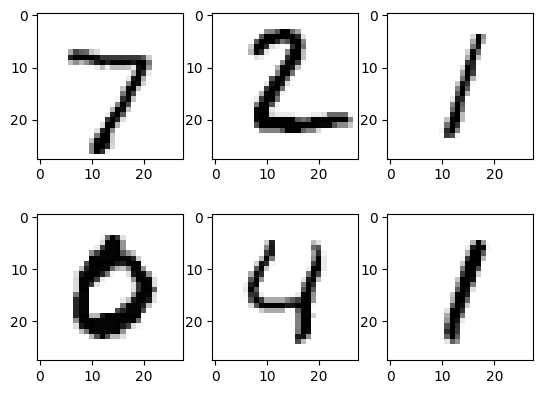

In [ ]:
examples = iter(test_loader)
example_data, example_targets = next(examples)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='binary')
plt.show()

# Train Model

In [ ]:
cfg = MnistConfig()
cfg.random_seed = 0
cfg.n_layers = 1
cfg.d_hidden = 300
cfg.num_epochs = 2 + 10 + 10
cfg.lr = 0.001
cfg.lr_decay = 0.5
cfg.lr_decay_step = 2
cfg.weight_decay = 0.5
cfg.rms_norm = False
cfg.bias = False
cfg.noise_sparse = 0
cfg.noise_dense = 0.33
cfg.layer_noise = 0.33
cfg.logit_bias = False

model = MnistModel(cfg).to("cuda")

#Define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
linearLR = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1, total_iters = 2)
stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.lr_decay_step, gamma=cfg.lr_decay)
constLR = torch.optim.lr_scheduler.ConstantLR(optimizer, factor = cfg.lr_decay**(10/cfg.lr_decay_step), total_iters = 1000)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[linearLR, stepLR, constLR], milestones=[2, 13])

model.train(train_loader, test_loader, optimizer = optimizer, scheduler = scheduler)

Accuracy on validation set: 10.46 %
Epoch [1/22], Step [100/600], Loss: 2.2839
Epoch [1/22], Step [200/600], Loss: 2.2560
Epoch [1/22], Step [300/600], Loss: 2.1249
Epoch [1/22], Step [400/600], Loss: 1.8977
Epoch [1/22], Step [500/600], Loss: 1.6340
Epoch [1/22], Step [600/600], Loss: 1.3308
learning rate = 0.000505
Accuracy on validation set: 68.3 %
Epoch [2/22], Step [100/600], Loss: 0.7716
Epoch [2/22], Step [200/600], Loss: 0.3052
Epoch [2/22], Step [300/600], Loss: 0.3305
Epoch [2/22], Step [400/600], Loss: 0.3832
Epoch [2/22], Step [500/600], Loss: 0.3450
Epoch [2/22], Step [600/600], Loss: 0.2387
learning rate = 0.001


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Accuracy on validation set: 95.35 %
Epoch [3/22], Step [100/600], Loss: 0.3683
Epoch [3/22], Step [200/600], Loss: 0.3652
Epoch [3/22], Step [300/600], Loss: 0.2359
Epoch [3/22], Step [400/600], Loss: 0.3407
Epoch [3/22], Step [500/600], Loss: 0.2495
Epoch [3/22], Step [600/600], Loss: 0.3260
learning rate = 0.001
Accuracy on validation set: 95.57 %
Epoch [4/22], Step [100/600], Loss: 0.1751
Epoch [4/22], Step [200/600], Loss: 0.2164
Epoch [4/22], Step [300/600], Loss: 0.3852
Epoch [4/22], Step [400/600], Loss: 0.1407
Epoch [4/22], Step [500/600], Loss: 0.2051
Epoch [4/22], Step [600/600], Loss: 0.3004
learning rate = 0.0005
Accuracy on validation set: 96.61 %
Epoch [5/22], Step [100/600], Loss: 0.1499
Epoch [5/22], Step [200/600], Loss: 0.1935
Epoch [5/22], Step [300/600], Loss: 0.1574
Epoch [5/22], Step [400/600], Loss: 0.2172
Epoch [5/22], Step [500/600], Loss: 0.1878
Epoch [5/22], Step [600/600], Loss: 0.2051
learning rate = 0.0005
Accuracy on validation set: 97.25 %
Epoch [6/22], 

# Eigendecomposition





## Eigenvectors

In [ ]:
W = model.layers[0].linear1.weight.to("cpu").detach()
V = model.layers[0].linear2.weight.to("cpu").detach()
W_out = model.linear_out.weight.to("cpu").detach()
W_in = model.linear_in.weight.to("cpu").detach()

B = einops.einsum(W_out, W, V, "class h, h in1, h in2 -> class in1 in2")
B_proj = 0.5 * B + 0.5 * B.transpose(-2,-1)

/usr/local/lib/python3.10/dist-packages/einops/parsing.py:137: RuntimeWarning: It is discouraged to use axes names that are keywords: class
  warnings.warn("It is discouraged to use axes names that are keywords: {}".format(name), RuntimeWarning)


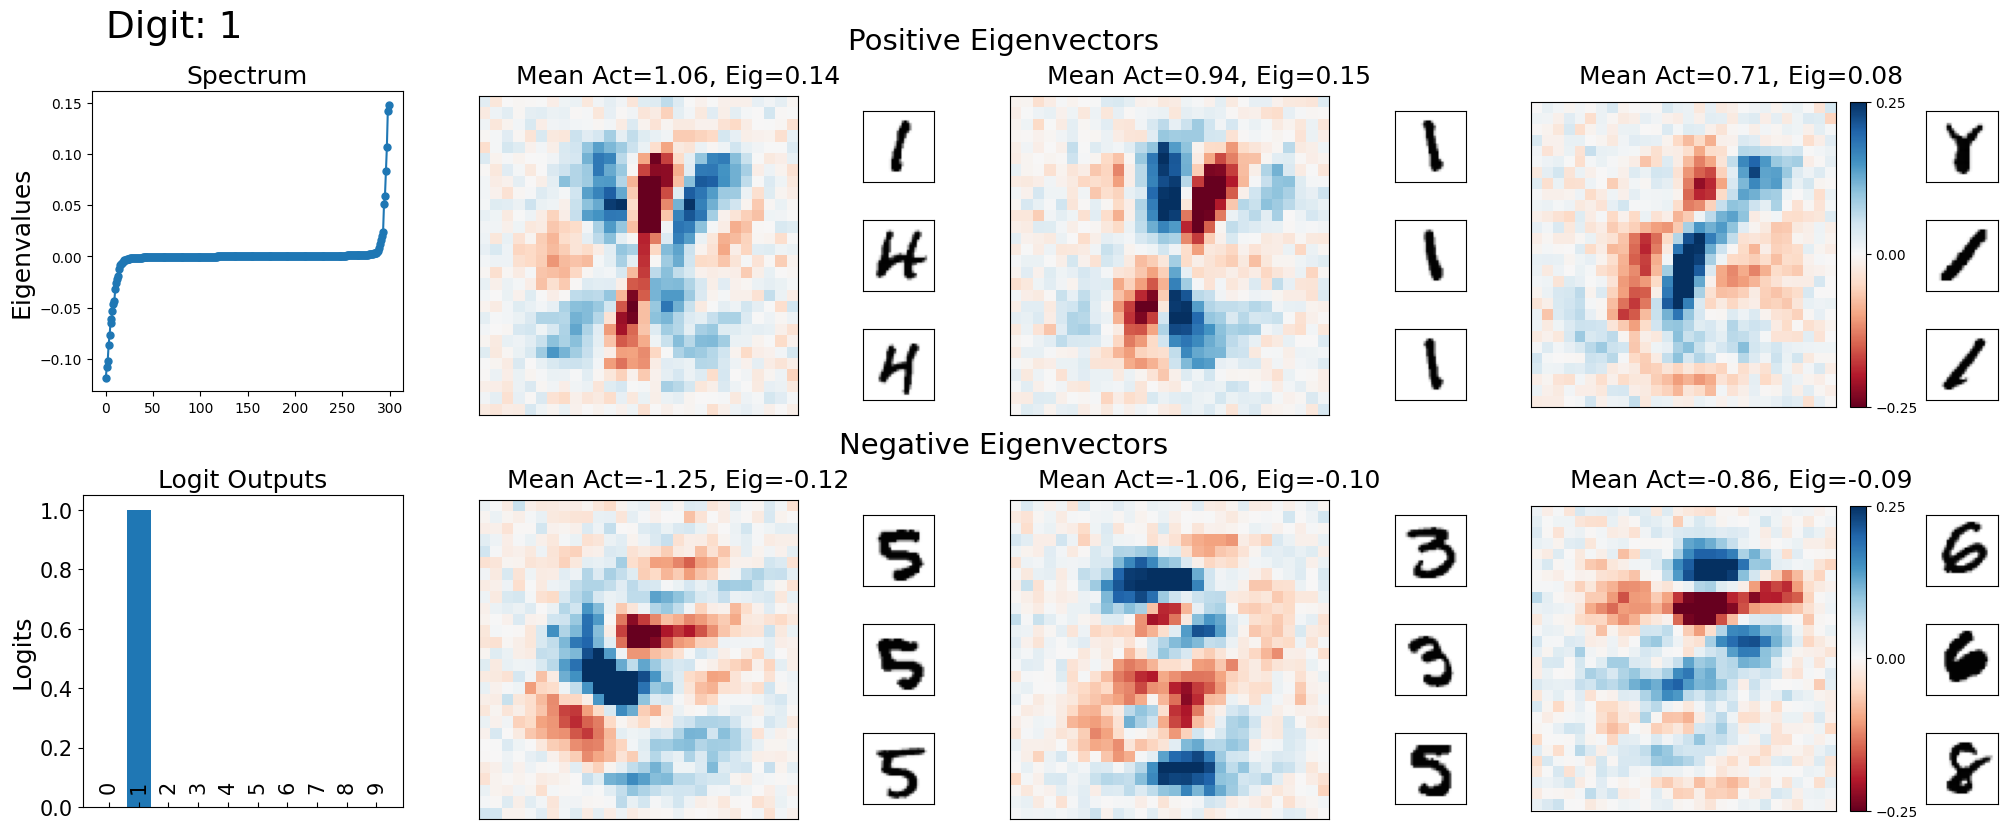

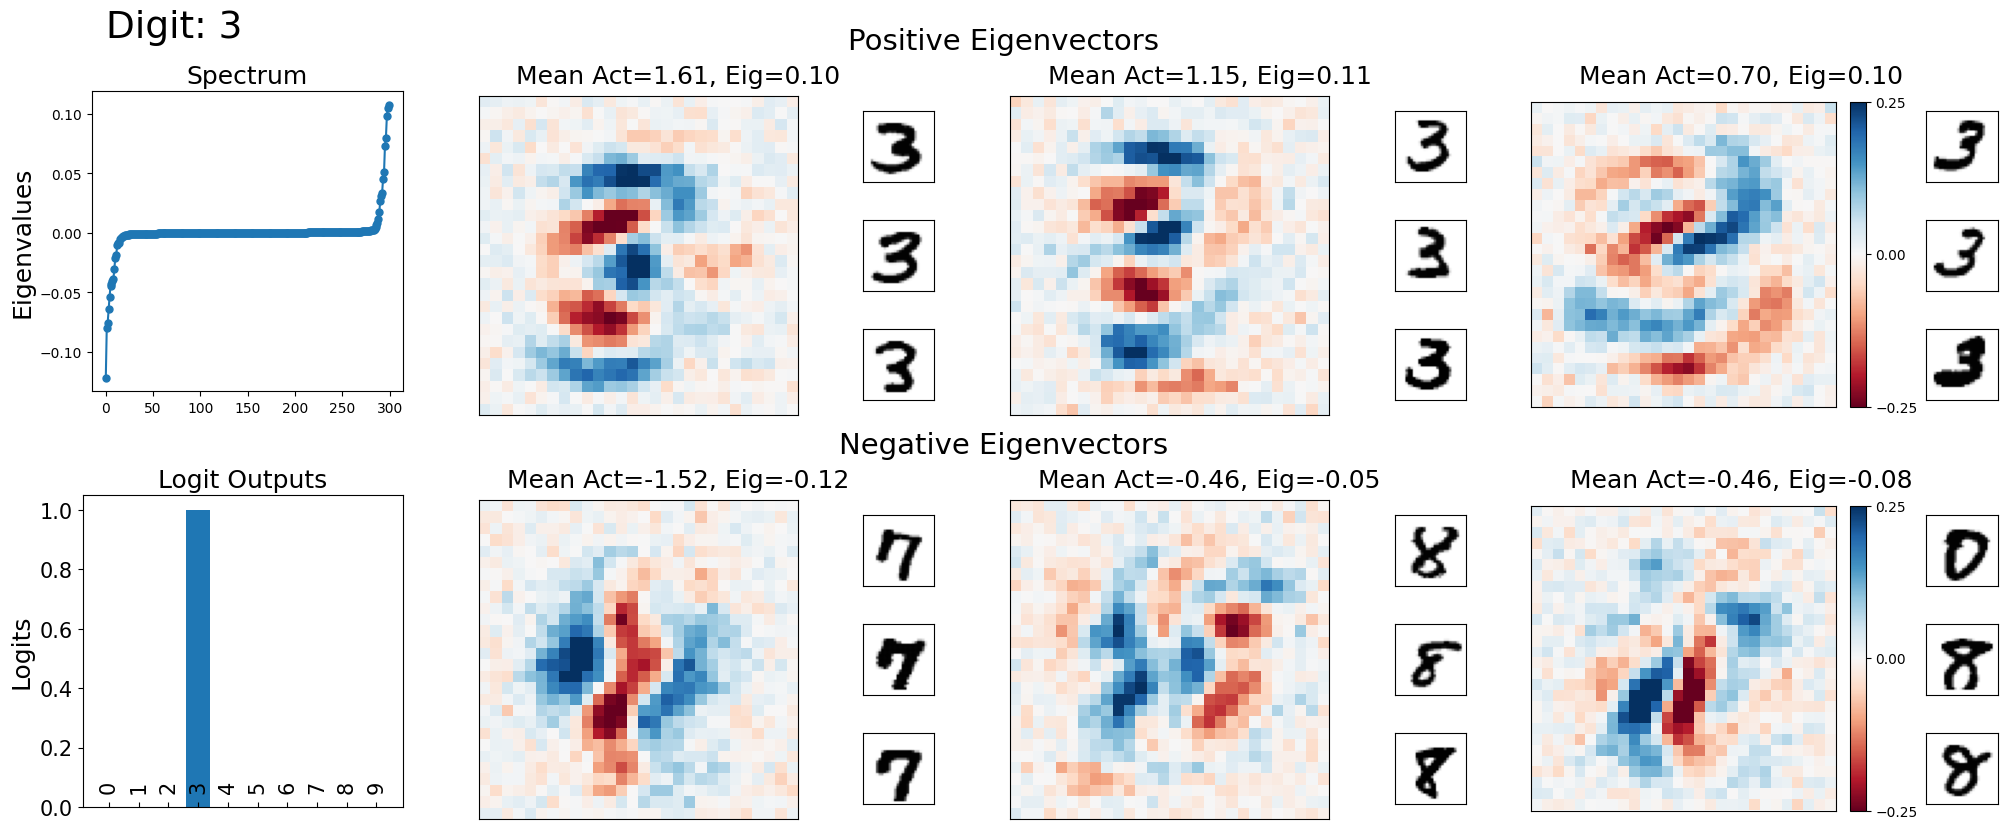

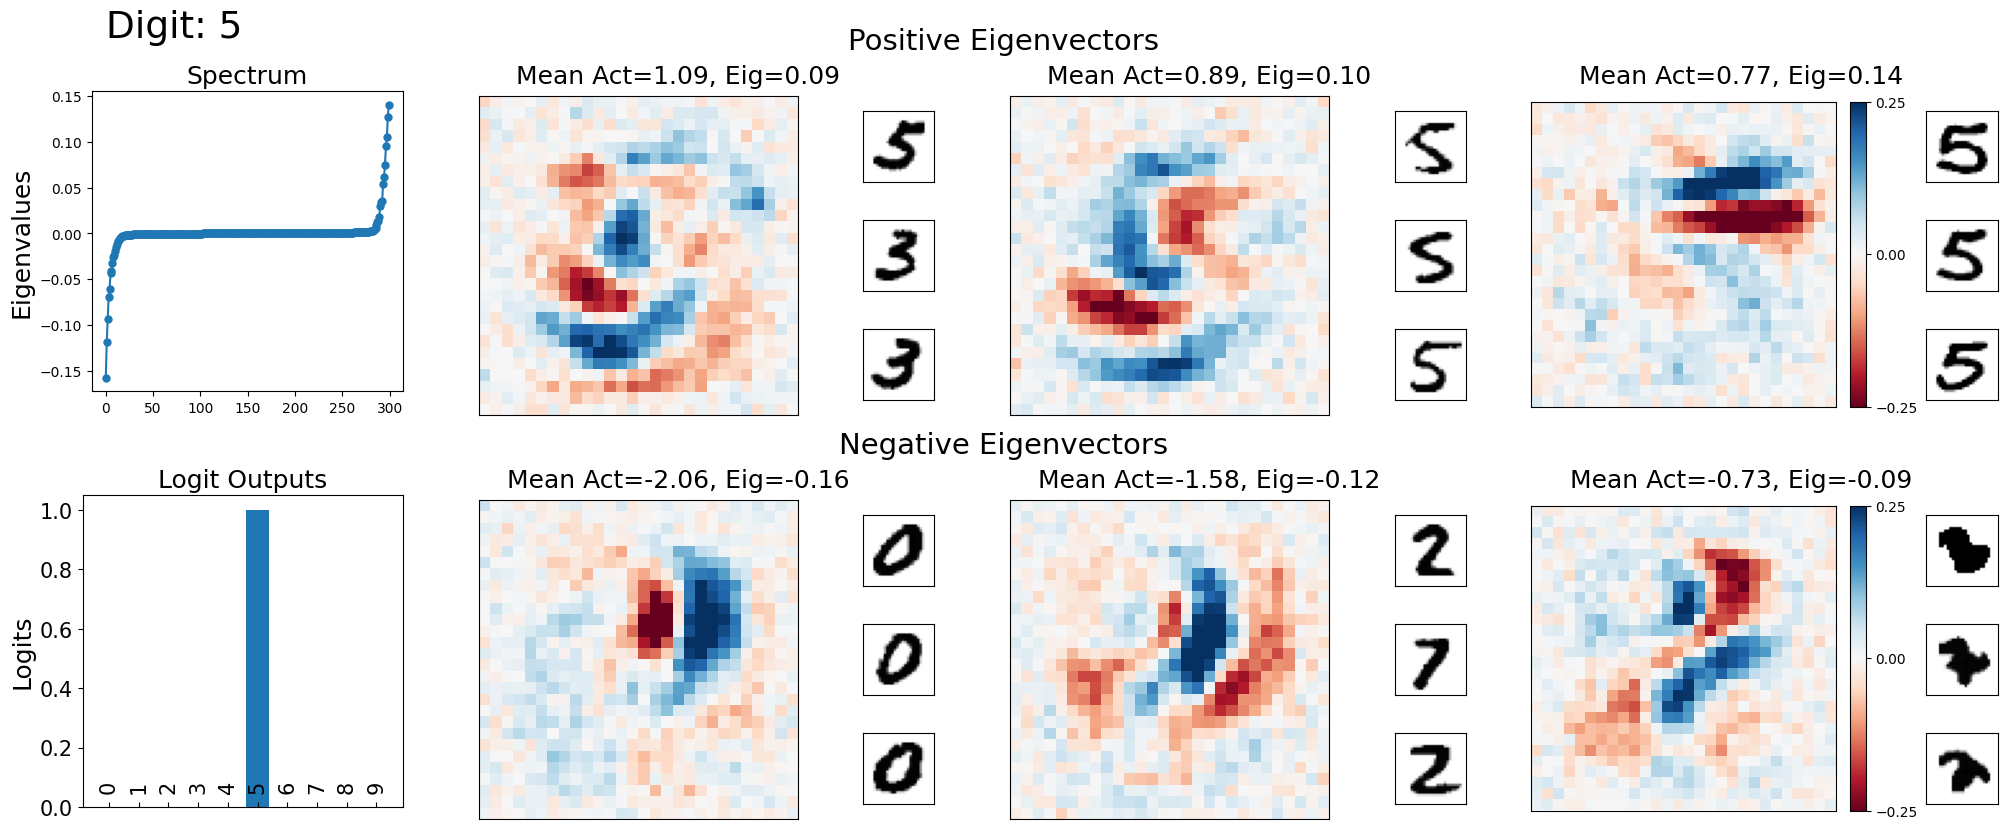

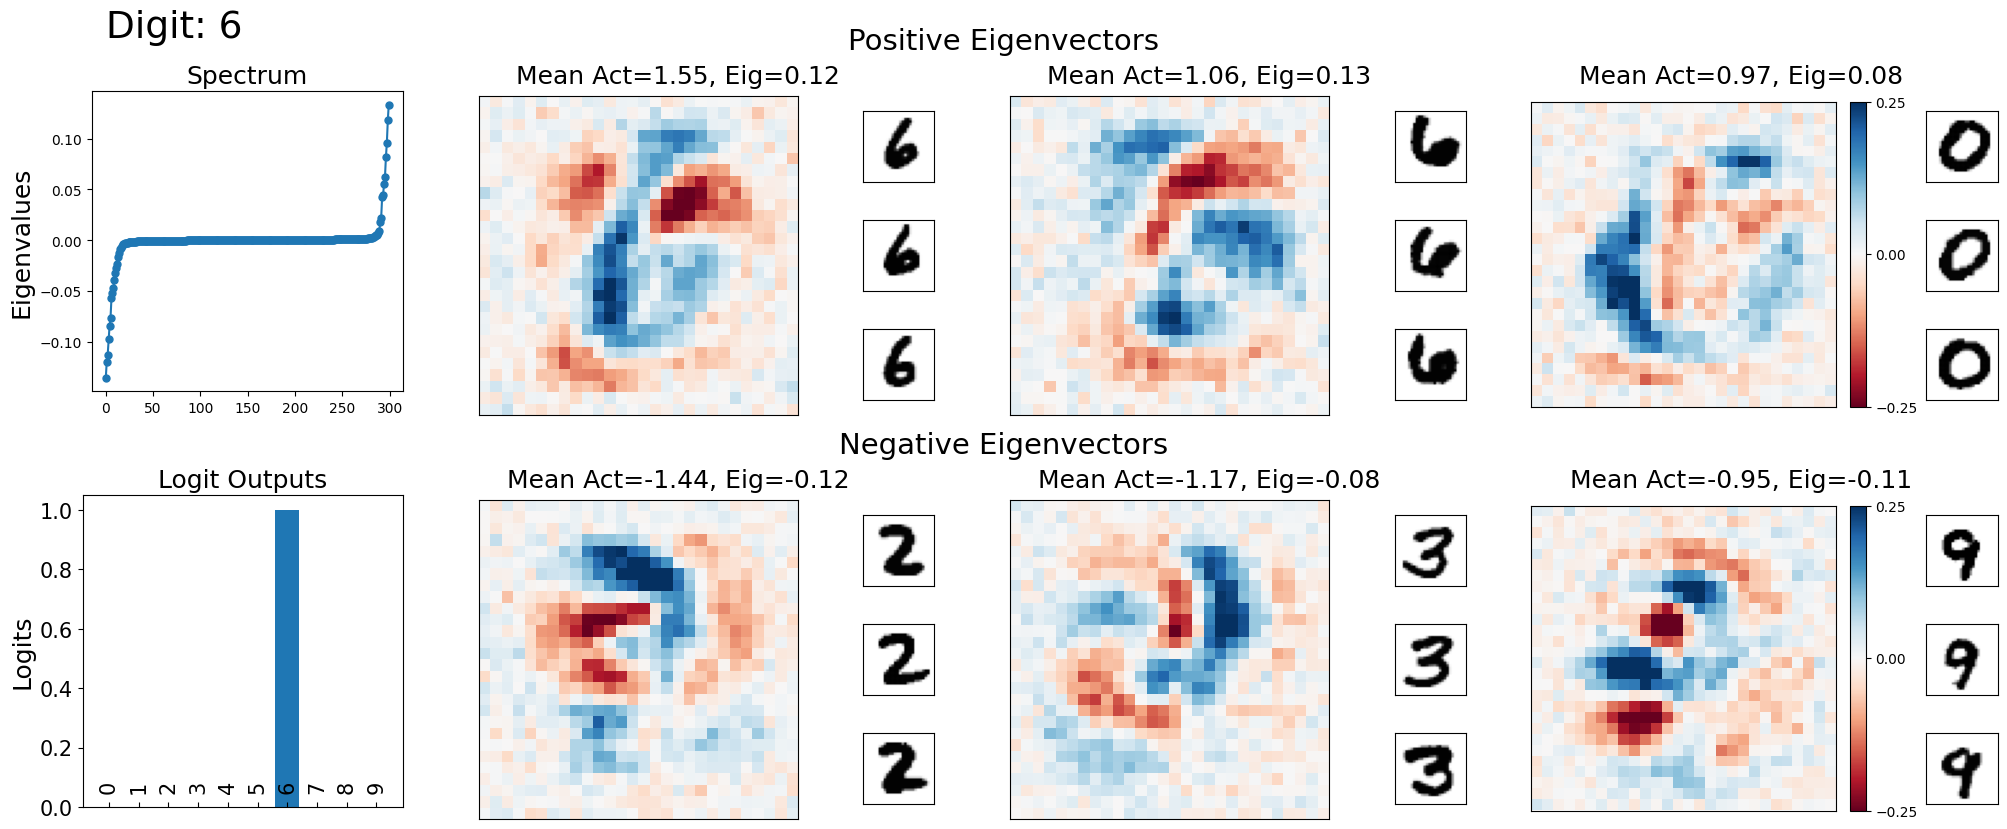

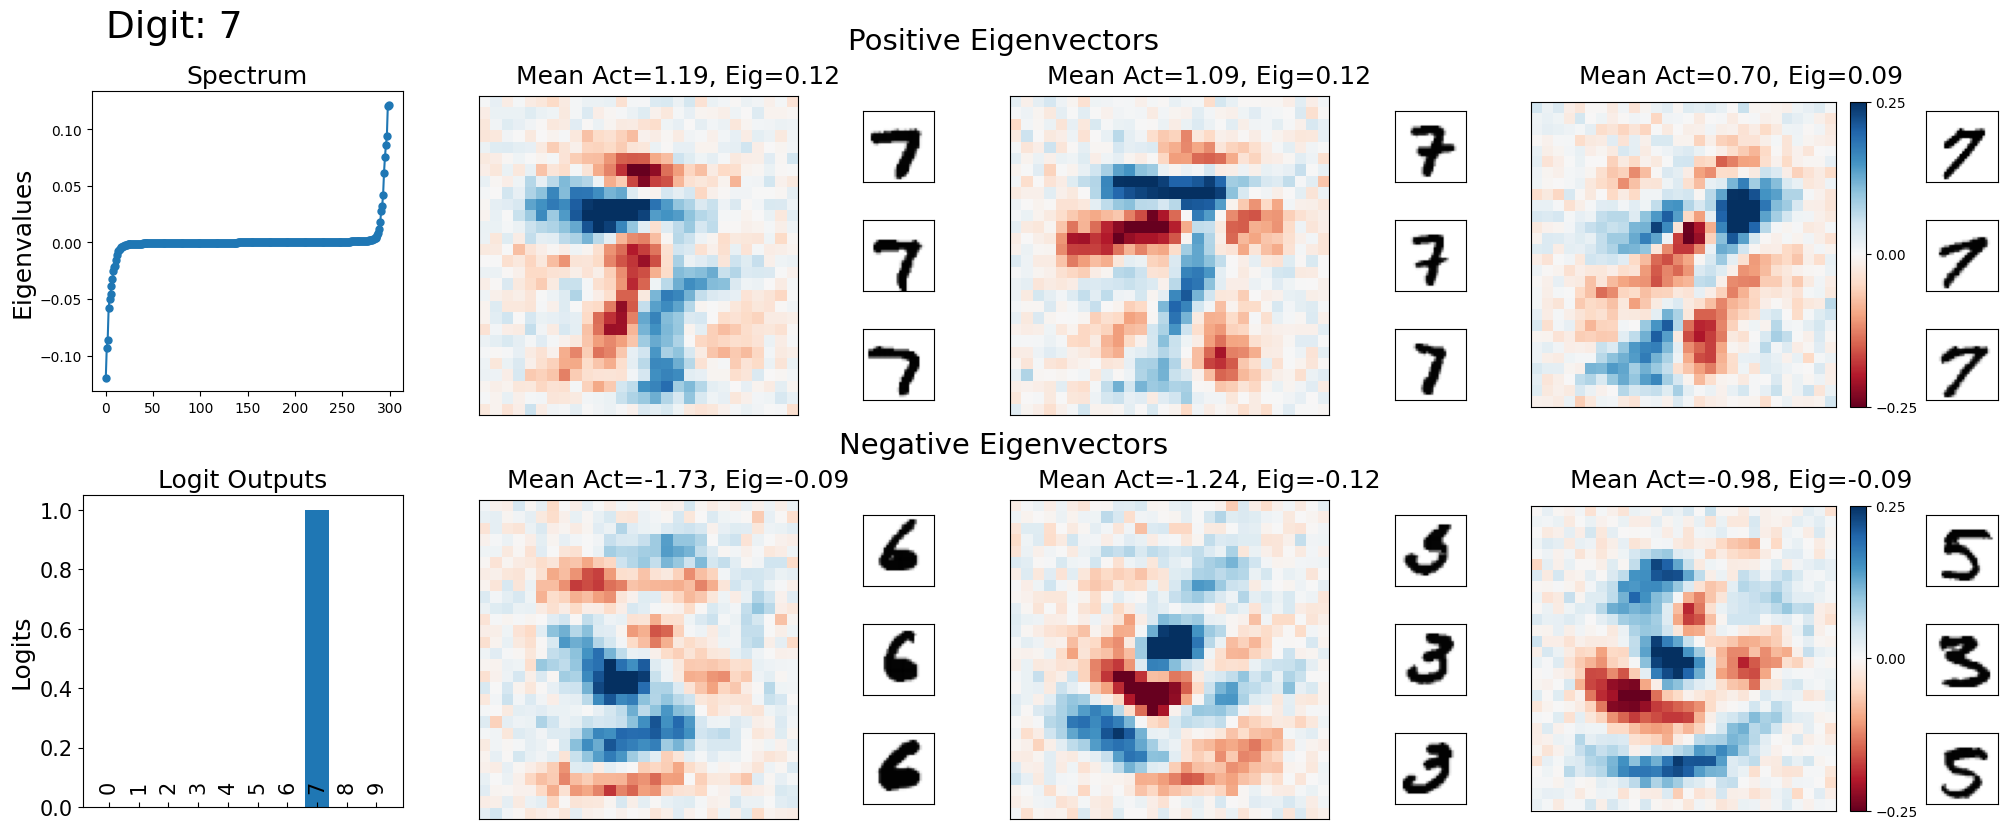

In [ ]:
logits = torch.eye(B_proj.shape[0], B_proj.shape[0])
eig_plotter = EigenvectorPlotter(B_proj, logits, dataset=train_dataset, Embed = W_in)

for i in range(10):
    eig_plotter.plot_component(i, suptitle=f"Digit: {i}", vmax=0.25,
                               classes = range(10), topk_eigs = 3, sort='activations')

# plt.tight_layout()

In [ ]:
# save figures
file_pre = f'/content/drive/MyDrive/AI Safety/Bilinear Features/Noise Regulation/noise_reg_noise_only_digit_'
logits = torch.eye(B_proj.shape[0], B_proj.shape[0])
eig_plotter = EigenvectorPlotter(B_proj, logits, dataset=train_dataset, Embed = W_in)

for i in range(10):
    eig_plotter.plot_component(i, suptitle=f"Digit: {i}", vmax=0.25,
                               classes = range(10), topk_eigs = 3, sort='activations',
                               filename = file_pre+str(i)+'.png')



## Activation Distribution

In [ ]:
class_idx = 3

Q = B_proj[class_idx]
eigvals, eigvecs = torch.linalg.eigh(Q)
mask = eigvals > 0.01
eigvals = eigvals[mask]
eigvecs = eigvecs[:,mask]
eigvecs = W_in.T @ eigvecs

In [ ]:
dataset = train_dataset
img_size = (28,28)

images = dataset.data.reshape(-1, img_size[0]*img_size[1])/255
labels = dataset.targets
# mask = dataset.targets == class_idx
# images = images[mask]
sims = images @ eigvecs
acts = eigvals * (sims)**2

In [ ]:
eig_idx = -3

plt.figure(figsize=(8,3),dpi=150, layout='compressed')
plt.subplot(1,3,1)
plt.imshow(eigvecs[:,eig_idx].reshape(img_size), cmap='RdBu', vmin=-0.25, vmax=0.25)
plt.xticks([])
plt.yticks([])
plt.title('Eigenvector')

plt.subplot(1,3,2)
plt.hist(sims[:,eig_idx],100);
plt.xlabel('Dot Product')
plt.ylabel('Count')
plt.yscale('log')
plt.xlim(-15,15)

plt.subplot(1,3,3)
plt.hist(acts[:,eig_idx],100);
plt.xlabel('Activation')
plt.ylabel('Count')
plt.yscale('log')
# plt.xlim(-15,15)

In [ ]:
plt.figure(figsize=(8,3),dpi=150, layout='compressed')
plt.subplot(1,3,1)
plt.imshow(eigvecs[:,eig_idx].reshape(img_size), cmap='RdBu', vmin=-0.25, vmax=0.25)
plt.xticks([])
plt.yticks([])
plt.title('Eigenvector')

plt.subplot(1,3,2)
for digit in range(10):
    mask = labels==digit
    plt.hist(sims[mask,eig_idx],100, alpha=0.3, label=digit);
plt.xlabel('Dot Product')
plt.ylabel('Count')
plt.yscale('log')
plt.xlim(-15,15)

plt.subplot(1,3,3)
for digit in range(10):
    mask = labels==digit
    plt.hist(acts[mask,eig_idx],100, alpha=0.3, label=digit);
plt.xlabel('Activation')
plt.ylabel('Count')
plt.yscale('log')
plt.legend()
# plt.xlim(-15,15)

In [ ]:
dataset = train_dataset
img_size = (28,28)
images = dataset.data.reshape(-1, img_size[0]*img_size[1])/255
images = images.cuda()

noise = model.cfg.noise_dense * torch.randn_like(images)
_ = model.forward(images.mean(dim=0, keepdim=True) + noise, inference=False)
mlp_inputs_noisy = model.layers[0].input

_ = model.forward(images, inference=True)
mlp_inputs = model.layers[0].input

In [ ]:
eigvals, eigvecs = torch.linalg.eigh(B_proj)

sims = einops.einsum(eigvecs, mlp_inputs.cpu().detach(), "digit h eig, b h -> digit eig b")
acts = eigvals.unsqueeze(-1) * (sims)**2

sims_noisy = einops.einsum(eigvecs, mlp_inputs_noisy.cpu().detach(), "digit h eig, b h -> digit eig b")
acts_noisy = eigvals.unsqueeze(-1) * (sims)**2

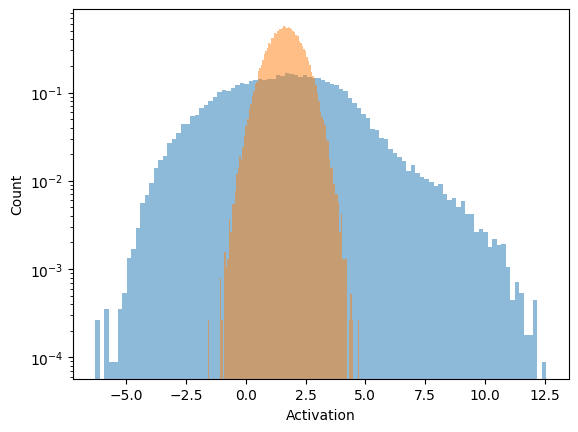

In [ ]:
cls_idx = 4
eig_idx = -1

plt.hist(sims[cls_idx,eig_idx],100, alpha=0.5, density=True);
plt.hist(sims_noisy[cls_idx,eig_idx],100, alpha=0.5, density=True);

plt.xlabel('Activation')
plt.ylabel('Count')
plt.yscale('log')

## Mean Activations

In [ ]:
eigvals_list = []
eigvecs_list = []
for digit in range(10):
    with torch.no_grad():
        Q = B_proj[digit].reshape(model.cfg.d_hidden, model.cfg.d_hidden)
        eigvals, eigvecs = torch.linalg.eigh(Q)
    eigvals_list.append(eigvals)
    eigvecs_list.append(eigvecs)
eigvals = torch.stack(eigvals_list, dim=0)
eigvecs = torch.stack(eigvecs_list, dim=0)

In [ ]:
img_size = (28,28)
freq_thresh = 0.01

acts_list = []
avg_img = torch.zeros(img_size[0]*img_size[1])
count = 0
for images, labels in train_loader:
    images = images.reshape(-1, img_size[0]*img_size[1])
    acts = eigvals * (einops.einsum(eigvecs, W_in, images, "digit h eig, h pix, b pix  -> b digit eig"))**2
    acts_list.append(acts)
    avg_img += images.mean(dim=0)
    count += acts.shape[0]

avg_img /= count
acts = torch.cat(acts_list, dim=0)
mean_acts = acts.mean(dim=0)
freqs = (acts > freq_thresh).float().mean(dim=0)

large_acts = acts.clone()
large_acts[large_acts <= freq_thresh] = 0
mean_large_acts = large_acts.sum(dim=0) / (large_acts > 0).sum(dim=0)

(-1.0, 31.0)

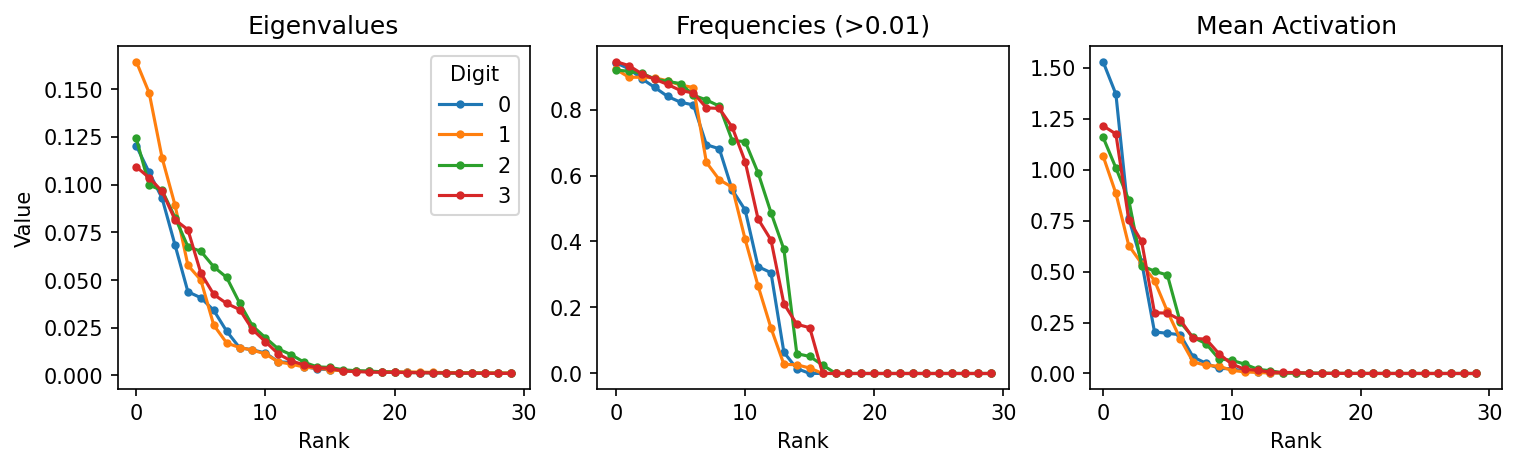

In [ ]:
digits = [0,1,2,3]
num = 30

plt.figure(figsize=(10,3),dpi=150, layout='compressed')

plt.subplot(1,3,1)
for digit in digits:
    x = eigvals[digit].sort(descending=True).values
    plt.plot(x[:num], '.-', label=f"{digit}")
plt.title(f'Eigenvalues')
plt.legend(title='Digit')
plt.xlabel('Rank')
plt.ylabel('Value')

plt.subplot(1,3,2)
for digit in digits:
    x = freqs[digit].sort(descending=True).values
    plt.plot(x[:num], '.-', label=f"{digit}")
# plt.legend(title='Digit')
plt.title(f'Frequencies (>{freq_thresh})')
plt.xlabel('Rank')

plt.subplot(1,3,3)
for digit in digits:
    x = mean_acts[digit].sort(descending=True).values
    plt.plot(x[:num], '.-', label=f"{digit}")
# plt.legend(title='Digit')
plt.title(f'Mean Activation')
plt.xlabel('Rank')
plt.xlim([-1,num+1])

## Performance Curve

In [ ]:
W = model.layers[0].linear1.weight.to("cpu").detach()
V = model.layers[0].linear2.weight.to("cpu").detach()
W_out = model.linear_out.weight.to("cpu").detach()
W_in = model.linear_in.weight.to("cpu").detach()

B = get_B_tensor(W, V)
B = einops.rearrange(B, "out (in1 in2) -> out in1 in2", in1 = model.cfg.d_hidden)
B_proj = einops.einsum(W_out, B, "class h2, h2 in1 in2-> class in1 in2")

eigvals, eigvecs = torch.linalg.eigh(B_proj)

/usr/local/lib/python3.10/dist-packages/einops/parsing.py:137: RuntimeWarning: It is discouraged to use axes names that are keywords: class
  warnings.warn("It is discouraged to use axes names that are keywords: {}".format(name), RuntimeWarning)


In [ ]:
class SingleLayerTopEigsModel(torch.nn.Module):
    def __init__(self, eigvecs, eigvals, W_in):
        super().__init__()
        self.eigvecs = eigvecs
        self.eigvals = eigvals
        self.W_in = W_in

    def set_activations(self):
        images = train_dataset.data.reshape(-1, 28*28)/255 #convert uint8 to float
        sims = einops.einsum(images, self.W_in, self.eigvecs, "b pix, h pix, class h eig -> b class eig")
        self.acts = (self.eigvals.unsqueeze(0) * (sims)**2).mean(dim=0)

    def get_eigvecs(self, topk = None, topk_method = 'paired'):
        if topk is None:
            return self.eigvecs, self.eigvals

        if topk_method == 'paired':
            #take topk positive and topk negative eigenvectors
            eigvecs = torch.cat([self.eigvecs[:, :, :topk], self.eigvecs[:, :, -topk:]], dim=-1)
            eigvals = torch.cat([self.eigvals[:, :topk], self.eigvals[:, -topk:]], dim=-1)
        elif topk_method == 'max_eigs':
            idxs = self.eigvals.abs().sort(descending=True, dim=-1).indices
            eigvals = torch.stack([self.eigvals[i,idxs[i,:topk]] for i in range(self.eigvals.shape[0])], dim=0)
            eigvecs = torch.stack([self.eigvecs[i, :, idxs[i,:topk]] for i in range(self.eigvecs.shape[0])], dim=0)
        elif topk_method == 'max_act':
            idxs = self.acts.abs().sort(descending=True, dim=-1).indices
            eigvals = torch.stack([self.eigvals[i,idxs[i,:topk]] for i in range(self.eigvals.shape[0])], dim=0)
            eigvecs = torch.stack([self.eigvecs[i, :, idxs[i,:topk]] for i in range(self.eigvecs.shape[0])], dim=0)
        return eigvecs, eigvals

    def forward(self, x, topk = None, topk_method = 'paired'):
        x = x @ self.W_in.T

        eigvecs, eigvals = self.get_eigvecs(topk = topk, topk_method = topk_method)
        sims = einops.einsum(eigvecs, x, "class h eig, b h -> b class eig")
        acts = eigvals.unsqueeze(0) * (sims)**2
        logits = acts.sum(dim=-1)
        return logits

    def criterion(self, output, labels):
        return nn.CrossEntropyLoss()(output, labels)

    def validation_accuracy(self, test_loader, topk = None, topk_method = 'paired', print_acc=True):
        # In test phase, we don't need to compute gradients (for memory efficiency)
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            loss_sum = 0
            count = 0
            if topk_method == 'max_act':
                self.set_activations()
            for images, labels in test_loader:
                images = images.reshape(-1, 28*28)
                labels = labels
                outputs = self.forward(images, topk = topk, topk_method = topk_method)
                # max returns (value ,index)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
                loss_sum += self.criterion(outputs, labels).item()
                count += 1

            acc = 100.0 * n_correct / n_samples
            loss = loss_sum / count
            if print_acc:
              print(f'Accuracy on validation set: {acc} %')
        return acc, loss

In [ ]:
eig_model = SingleLayerTopEigsModel(eigvecs, eigvals, W_in)

topks = np.arange(1,40)
accs = []
losses = []
for k in topks:
    acc, loss = eig_model.validation_accuracy(test_loader, topk = k, topk_method='max_act', print_acc=False)
    accs.append(acc)
    losses.append(loss)

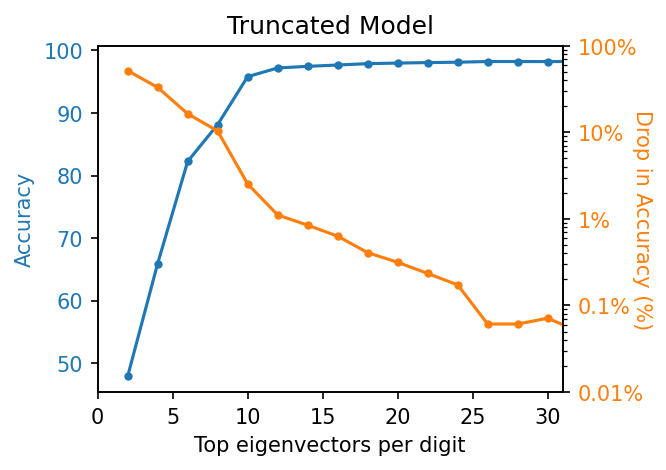

In [ ]:
fig, ax1 = plt.subplots(figsize=(4,3), dpi=150)
ax1.plot(2*topks, accs, '.-', color='C0')
ax1.set_xlabel('Top eigenvectors per digit')
ax1.set_ylabel('Accuracy', color='C0')
ax1.set_xticks([0,5, 10,15,20,25,30], [0,5,10,15,20,25,30])
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_title('Truncated Model')
ax1.set_xlim(0,31)

ax2 = ax1.twinx()

accs = np.array(accs)
base_acc, base_loss =  eig_model.validation_accuracy(test_loader, print_acc=False)
acc_drop = (base_acc - accs) / base_acc

ax2.plot(2*topks, 100 * acc_drop, '.-', color='C1')
ax2.set_yscale('log')
ax2.set_ylabel('Drop in Accuracy (%)', color='C1', rotation=270)
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_yticks([0.01, 0.1, 1, 10, 100], ['0.01%', '0.1%', '1%', '10%', '100%'])


In [ ]:
fig, ax1 = plt.subplots(figsize=(4,3), dpi=150)
ax1.plot(topks, accs, '.-', color='C0')
ax1.set_xlabel('Top eigenvectors per digit')
ax1.set_ylabel('Accuracy', color='C0')
ax1.set_xticks([0,5, 10,15,20,25,30], [0,5,10,15,20,25,30])
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_title('Truncated Model')
ax1.set_xlim(0,31)

ax2 = ax1.twinx()

accs = np.array(accs)
base_acc, base_loss =  eig_model.validation_accuracy(test_loader, print_acc=False)
acc_drop = (base_acc - accs) / base_acc

ax2.plot( topks, 100 * acc_drop, '.-', color='C1')
ax2.set_yscale('log')
ax2.set_ylabel('Drop in Accuracy (%)', color='C1', rotation=270)
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_yticks([0.01, 0.1, 1, 10, 100], ['0.01%', '0.1%', '1%', '10%', '100%'])


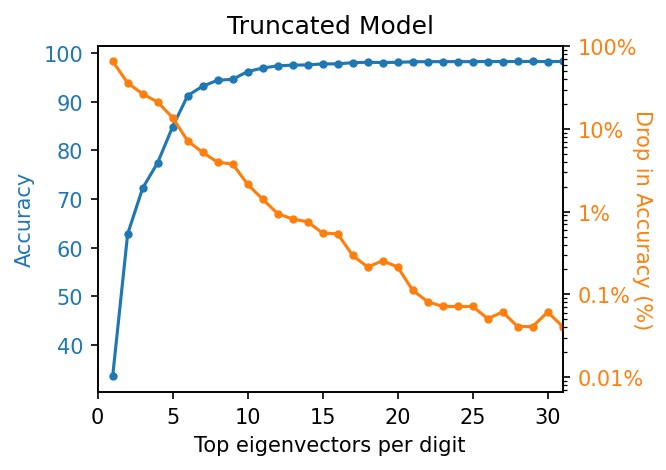

In [ ]:
fig, ax1 = plt.subplots(figsize=(4,3), dpi=150)
ax1.plot(topks, accs, '.-', color='C0')
ax1.set_xlabel('Top eigenvectors per digit')
ax1.set_ylabel('Accuracy', color='C0')
ax1.set_xticks([0,5, 10,15,20,25,30], [0,5,10,15,20,25,30])
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_title('Truncated Model')
ax1.set_xlim(0,31)

ax2 = ax1.twinx()

accs = np.array(accs)
base_acc, base_loss =  eig_model.validation_accuracy(test_loader, print_acc=False)
acc_drop = (base_acc - accs) / base_acc

ax2.plot( topks, 100 * acc_drop, '.-', color='C1')
ax2.set_yscale('log')
ax2.set_ylabel('Drop in Accuracy (%)', color='C1', rotation=270)
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_yticks([0.01, 0.1, 1, 10, 100], ['0.01%', '0.1%', '1%', '10%', '100%'])

## Sparsified model

In [ ]:
class SparseModelConfig:
    def __init__(self):
        self.random_seed = 0

        self.l1_param = 0.1

        self.lr = 0.001
        self.lr_decay = 0.5
        self.lr_decay_step = 2

class SingleLayerSparseModel(torch.nn.Module):
    def __init__(self, cfg, eigvecs, eigvals, W_in):
        super().__init__()
        self.cfg = cfg
        self.eigvecs = torch.nn.Parameter(eigvecs, requires_grad=False)  # (cls, h, eig)
        self.eigvals = torch.nn.Parameter(eigvals, requires_grad=False) # (class, eig)
        self.W_in = torch.nn.Parameter(W_in, requires_grad=False)

        self.bias = torch.nn.Parameter(torch.zeros(eigvecs.shape[0], eigvecs.shape[2]))

    def forward(self, x):
        x = x.to(self.cfg.device)
        x = x @ self.W_in.T

        sims = einops.einsum(self.eigvecs, x, "class h eig, b h -> b class eig")
        acts = torch.nn.functional.relu((sims)**2 + self.bias)
        acts_out = self.eigvals.unsqueeze(0) * acts
        logits = acts_out.sum(dim=-1)
        return logits, acts

    def criterion(self, output, labels):
        return nn.CrossEntropyLoss()(output, labels)

    def validation_accuracy(self, test_loader, print_acc=True):
        # In test phase, we don't need to compute gradients (for memory efficiency)
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            loss_sum = 0
            count = 0
            for images, labels in test_loader:
                images = images.reshape(-1, 28*28).to(self.cfg.device)
                labels = labels.to(self.cfg.device)
                outputs, _ = self.forward(images)
                # max returns (value ,index)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
                loss_sum += self.criterion(outputs, labels).item()
                count += 1

            acc = 100.0 * n_correct / n_samples
            loss = loss_sum / count
            if print_acc:
              print(f'Accuracy on validation set: {acc} %, Loss: {loss:.4f}')
        return acc, loss

    def train(self, train_loader, test_loader, optimizer=None, scheduler=None):
        if optimizer is None:
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)

        num_epochs = self.cfg.num_epochs
        n_total_steps = len(train_loader)
        for epoch in range(num_epochs):
            _ = self.validation_accuracy(test_loader)
            for i, (images, labels) in enumerate(train_loader):
                # origin shape: [100, 1, 28, 28]
                # resized: [100, 784]
                images = images.reshape(-1, 28*28).to(self.cfg.device)
                labels = labels.to(self.cfg.device)

                # Forward pass
                logits, acts = self.forward(images)
                L1 = einops.rearrange(acts.abs(), "b class eig -> b (class eig)").mean().mean()
                L0 =  einops.einsum((acts > 0).float(), "b class eig -> b").mean()
                loss = self.criterion(logits, labels)
                loss_opt = loss + self.cfg.l1_param * L1

                # Backward and optimize
                optimizer.zero_grad()
                loss_opt.backward()
                optimizer.step()

                if (i+1) % 100 == 0:
                    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, L1: {L1.item(): .4f}, L0: {L0.item(): .4f}')

            if (scheduler is not None):
                scheduler.step()
                print(f'learning rate = {scheduler.get_last_lr()[0]}')
        _ = self.validation_accuracy(test_loader)

In [ ]:
eigvals, eigvecs = torch.linalg.eigh(B_proj)
W_in = model.linear_in.weight.cpu().detach()

In [ ]:
cfg = SparseModelConfig()
cfg.device = "cuda"
cfg.lr_param = 10

cfg.num_epochs = 50
cfg.lr = 0.05
cfg.lr_decay = 0.5
cfg.lr_decay_step = 2

sparse_model = SingleLayerSparseModel(cfg, eigvecs, eigvals, W_in).to(cfg.device)

optimizer = torch.optim.AdamW(sparse_model.parameters(), lr=cfg.lr)
# linearLR = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1, total_iters = 2)
# stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.lr_decay_step, gamma=cfg.lr_decay)
# constLR = torch.optim.lr_scheduler.ConstantLR(optimizer, factor = cfg.lr_decay**(10/cfg.lr_decay_step), total_iters = 1000)
# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[linearLR, stepLR, constLR], milestones=[2, 13])

sparse_model.train(train_loader, test_loader, optimizer = optimizer)

Accuracy on validation set: 98.03 %, Loss: 0.0746
Epoch [1/50], Step [100/600], Loss: 446.0851, L1:  490.3157, L0:  2938.9700
Epoch [1/50], Step [200/600], Loss: 47.9536, L1:  208.3645, L0:  2902.6299
Epoch [1/50], Step [300/600], Loss: 142.7029, L1:  146.1042, L0:  2886.5000
Epoch [1/50], Step [400/600], Loss: 6.8198, L1:  85.2336, L0:  2847.7300
Epoch [1/50], Step [500/600], Loss: 13.2012, L1:  71.5230, L0:  2808.2500
Epoch [1/50], Step [600/600], Loss: 2.0152, L1:  39.7889, L0:  2759.0100


KeyboardInterrupt: 

In [ ]:
dataset = train_dataset
img_size = (28,28)
images = dataset.data.reshape(-1, img_size[0]*img_size[1])/255
images = images.to(sparse_model.cfg.device)

logits, acts = sparse_model.forward(images)
acts = acts.cpu().detach()

In [ ]:
acts.shape

torch.Size([60000, 10, 300])

In [ ]:
cls_idx = 2
eig_idx = -10

plt.hist(acts[:, cls_idx, eig_idx], 100)
plt.yscale('log')

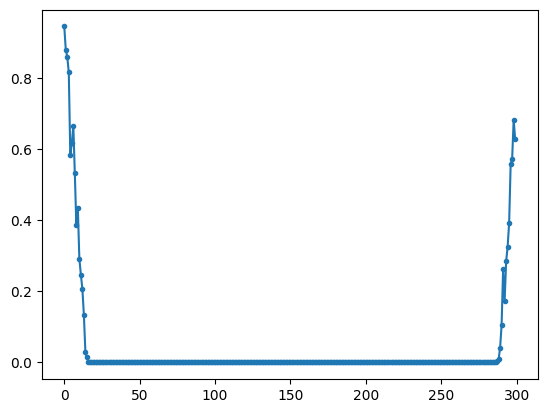

In [ ]:
act_freqs = (acts > 0).float().mean(dim=0)

cls_idx = 0

plt.plot(act_freqs[cls_idx],'.-')

In [ ]:
dataset = train_dataset
img_size = (28,28)
images = dataset.data.reshape(-1, img_size[0]*img_size[1])/255
images = images.cuda()

noise = model.cfg.noise_dense * torch.randn_like(images)
_ = model.forward(images.mean(dim=0, keepdim=True) + noise, inference=False)
mlp_inputs_noisy = model.layers[0].input

_ = model.forward(images, inference=True)
mlp_inputs = model.layers[0].input



In [ ]:
eigvals, eigvecs = torch.linalg.eigh(B_proj)

sims = einops.einsum(eigvecs, mlp_inputs.cpu().detach(), "digit h eig, b h -> digit eig b")
acts = eigvals.unsqueeze(-1) * (sims)**2

sims_noisy = einops.einsum(eigvecs, mlp_inputs_noisy.cpu().detach(), "digit h eig, b h -> digit eig b")
acts_noisy = eigvals.unsqueeze(-1) * (sims)**2

# Eigen-decomposition Reproducibility

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename_base = '/content/drive/MyDrive/AI Safety/Bilinear Features/Reproducibility Data/eigendecomp_20240520_v2'


## Train and save replicates

In [ ]:
cfg = MnistConfig()
cfg.random_seed = 0
cfg.n_layers = 1
cfg.d_hidden = 300
cfg.num_epochs = 2 + 10 + 40
cfg.lr = 0.001
cfg.lr_decay = 0.5
cfg.lr_decay_step = 2
cfg.weight_decay = 0.5
cfg.rms_norm = False
cfg.bias = False
cfg.noise_sparse = 0
cfg.noise_dense = 0.33
cfg.layer_noise = 0.33

cfgs = []
hidden_dims = [30, 50, 100, 300, 500, 1000]
for hidden_dim in hidden_dims:
    replicates = 5
    for i in range(replicates):
        cfg.random_seed = i
        cfg.d_hidden = hidden_dim
        cfg.filename = filename_base + f'_h{hidden_dim}_rep{i}.pt'
        cfgs.append(copy.deepcopy(cfg))

In [ ]:
def save_model_data(model, filename):
    accuracy, loss = model.validation_accuracy(test_loader)

    W = model.layers[0].linear1.weight.to("cpu").detach()
    V = model.layers[0].linear2.weight.to("cpu").detach()
    W_out = model.linear_out.weight.to("cpu").detach()
    W_in = model.linear_in.weight.to("cpu").detach()
    B = einops.einsum(W_out, W, V, "class h, h in1, h in2 -> class in1 in2")
    B_proj = 0.5 * B + 0.5 * B.transpose(-2,-1)

    eigvals, eigvecs = torch.linalg.eigh(B_proj)

    with open(filename, 'wb') as f:
        data = {'cfg':cfg, 'eigvals':eigvals, 'eigvecs':eigvecs, 'W_in': W_in,
                'accuracy':accuracy, 'loss':loss}
        torch.save(data, f)

In [ ]:
device = "cpu"
for i, cfg in enumerate(cfgs):
    model = MnistModel(cfg).to("cuda")

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    linearLR = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1, total_iters = 2)
    stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.lr_decay_step, gamma=cfg.lr_decay)
    constLR = torch.optim.lr_scheduler.ConstantLR(optimizer, factor = cfg.lr_decay**(10/cfg.lr_decay_step), total_iters = 1000)
    scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[linearLR, stepLR, constLR], milestones=[2, 13])

    model.train(train_loader, test_loader, optimizer = optimizer, scheduler = scheduler)

    with torch.no_grad():
        model = model.to(device)
        model.cfg.device = device
        save_model_data(model, model.cfg.filename)
        print(f'Saved {model.cfg.filename}')

Streaming output truncated to the last 5000 lines.
Epoch [4/52], Step [400/600], Loss: 0.1445
Epoch [4/52], Step [500/600], Loss: 0.2308
Epoch [4/52], Step [600/600], Loss: 0.2563
learning rate = 0.0005
Accuracy on validation set: 96.28 %
Epoch [5/52], Step [100/600], Loss: 0.2060
Epoch [5/52], Step [200/600], Loss: 0.2054
Epoch [5/52], Step [300/600], Loss: 0.1605
Epoch [5/52], Step [400/600], Loss: 0.1033
Epoch [5/52], Step [500/600], Loss: 0.1676
Epoch [5/52], Step [600/600], Loss: 0.1582
learning rate = 0.0005
Accuracy on validation set: 97.16 %
Epoch [6/52], Step [100/600], Loss: 0.0750
Epoch [6/52], Step [200/600], Loss: 0.1858
Epoch [6/52], Step [300/600], Loss: 0.1592
Epoch [6/52], Step [400/600], Loss: 0.2238
Epoch [6/52], Step [500/600], Loss: 0.1674
Epoch [6/52], Step [600/600], Loss: 0.0876
learning rate = 0.00025
Accuracy on validation set: 97.19 %
Epoch [7/52], Step [100/600], Loss: 0.2191
Epoch [7/52], Step [200/600], Loss: 0.1463
Epoch [7/52], Step [300/600], Loss: 0.10

## Across initializations

In [ ]:
hidden_dim = 300
replicates = 20

eigvals_list = []
eigvecs_list = []
W_in_list = []
for i in range(replicates):
    filename = filename_base + f'_h{hidden_dim}_rep{i}.pt'
    with open(filename, 'rb') as f:
        data = torch.load(f)
        cfg = data['cfg']
        eigvals_list.append(data['eigvals'])
        eigvecs_list.append(data['eigvecs'])
        W_in_list.append(data['W_in'])

In [ ]:
max_sims = []
for i in range(replicates):
    for j in range(replicates):
        if i == j:
            continue

        eigvecs0 = einops.einsum(eigvecs_list[i], W_in_list[i], "class h eig, h pix -> class eig pix")
        eigvecs1 = einops.einsum(eigvecs_list[j], W_in_list[j], "class h eig, h pix -> class eig pix")

        eigvecs0 = eigvecs0 / eigvecs0.norm(dim=-1, keepdim=True)
        eigvecs1 = eigvecs1 / eigvecs1.norm(dim=-1, keepdim=True)

        sims = einops.einsum(eigvecs0, eigvecs1,
                            "class eig1 pix, class eig2 pix  -> class eig1 eig2")
        max_sim = sims.abs().max(dim=-1).values
        max_sims.append(max_sim)
max_sims = torch.stack(max_sims)
max_sims_flat = max_sims.reshape(-1, max_sims.shape[-1])

Text(0, 0.5, 'Cosine Similarity')

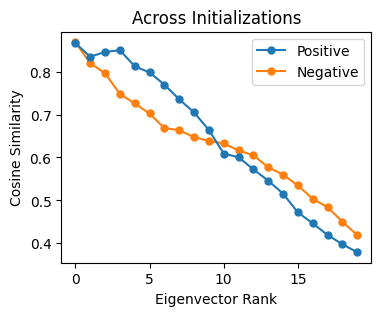

In [ ]:
# x = torch.arange(svd_components)
pos = max_sims_flat[:,-20:].mean(dim=0).flip(0)
neg = max_sims_flat[:,:20].mean(dim=0)

plt.figure(figsize=(4,3))
plt.plot(pos,'o-', markersize=5, label='Positive')
plt.plot(neg,'o-', markersize=5,zorder=-1, label='Negative')
plt.legend()
plt.title('Across Initializations')
plt.xlabel('Eigenvector Rank')
plt.ylabel('Cosine Similarity')

## Across Hidden Dims

In [ ]:
hidden_dims = [30, 50, 100, 300, 500, 1000]
replicates = 5

eigvals_dict = {}
eigvecs_dict = {}
W_in_dict = {}
for hidden_dim in hidden_dims:
    for i in range(replicates):
        filename = filename_base + f'_h{hidden_dim}_rep{i}.pt'
        with open(filename, 'rb') as f:
            data = torch.load(f)
            cfg = data['cfg']
            eigvals_dict[(hidden_dim, i)]= data['eigvals']
            eigvecs_dict[(hidden_dim, i)]= data['eigvecs']
            W_in_dict[(hidden_dim, i)]= data['W_in']

In [ ]:
max_sims_list = []

hidden1 = 300
for hidden2 in hidden_dims:
    max_sims = []
    for i in range(replicates):
        for j in range(replicates):
            if hidden1 == hidden2 and i == j:
                continue

            eigvecs0 = einops.einsum(eigvecs_dict[(hidden1,i)], W_in_dict[(hidden1,i)], "class h eig, h pix -> class eig pix")
            eigvecs1 = einops.einsum(eigvecs_dict[(hidden2,j)], W_in_dict[(hidden2,j)], "class h eig, h pix -> class eig pix")

            eigvecs0 = eigvecs0 / eigvecs0.norm(dim=-1, keepdim=True)
            eigvecs1 = eigvecs1 / eigvecs1.norm(dim=-1, keepdim=True)

            sims = einops.einsum(eigvecs0, eigvecs1,
                                "class eig1 pix, class eig2 pix  -> class eig1 eig2")
            max_sim = sims.abs().max(dim=-1).values
            max_sims.append(max_sim)
    max_sims = torch.stack(max_sims)
    max_sims = max_sims.reshape(-1, max_sims.shape[-1])
    max_sims_list.append(max_sims.mean(dim=0))

/usr/local/lib/python3.10/dist-packages/einops/parsing.py:137: RuntimeWarning: It is discouraged to use axes names that are keywords: class
  warnings.warn("It is discouraged to use axes names that are keywords: {}".format(name), RuntimeWarning)


([<matplotlib.axis.XTick at 0x7de7c934d3f0>,
 [Text(0, 0, '30'),
  Text(1, 0, '50'),
  Text(2, 0, '100'),
  Text(3, 0, '300'),
  Text(4, 0, '500'),
  Text(5, 0, '1000')])

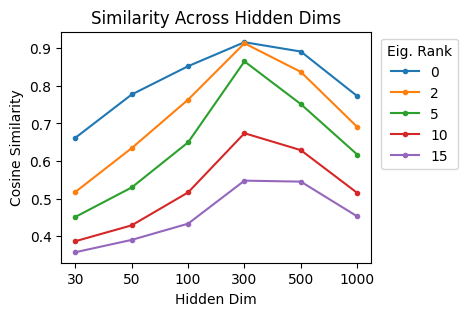

In [ ]:
plt.figure(figsize=(4,3))

ranks = [0, 2, 5, 10, 15]
hiddens = np.array(hidden_dims)

sims = []
for i, hidden in enumerate(hiddens):
    positives = max_sims_list[i].flip(0)[ranks]
    sims.append(positives)
sims = torch.stack(sims)

for i in range(len(ranks)):
    plt.plot(sims[:,i], '.-', label=f'{ranks[i]}')

plt.legend(title='Eig. Rank', bbox_to_anchor=(1.01, 1))
plt.title('Similarity Across Hidden Dims')
plt.xlabel('Hidden Dim')
plt.ylabel('Cosine Similarity')
plt.xticks(range(len(hiddens)), hiddens)

Text(0, 0.5, 'Cosine Similarity')

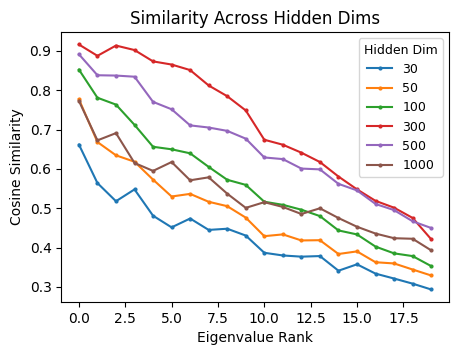

In [ ]:
plt.figure(figsize=(5,3.5))

for i in range(len(hidden_dims)):
    plt.plot(max_sims_list[i][-20:].flip(0), '.-', label=f'{hidden_dims[i]}', markersize=4)

plt.legend(title='Hidden Dim', title_fontsize=9, prop={'size':9})
plt.title('Similarity Across Hidden Dims')
plt.xlabel('Eigenvalue Rank')
plt.ylabel('Cosine Similarity')
# plt.xticks(range(len(hiddens)), hiddens)

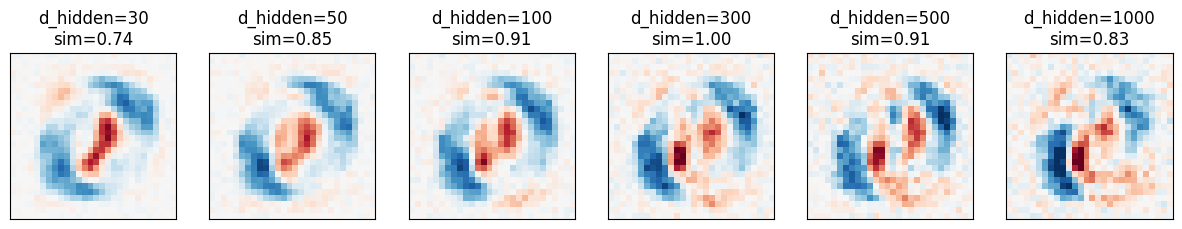

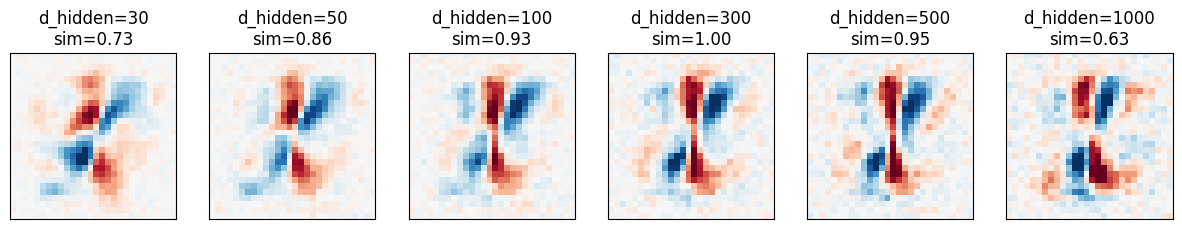

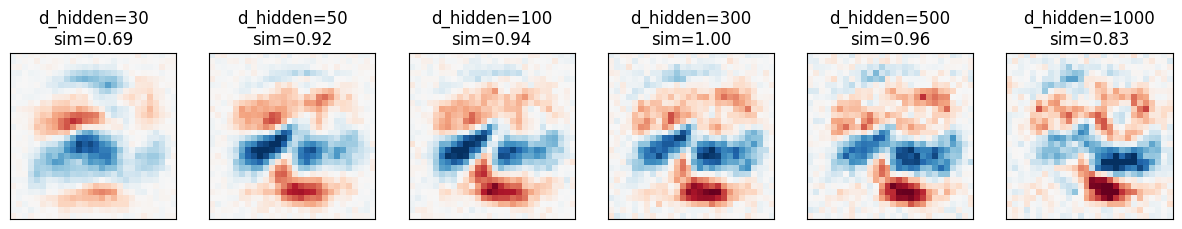

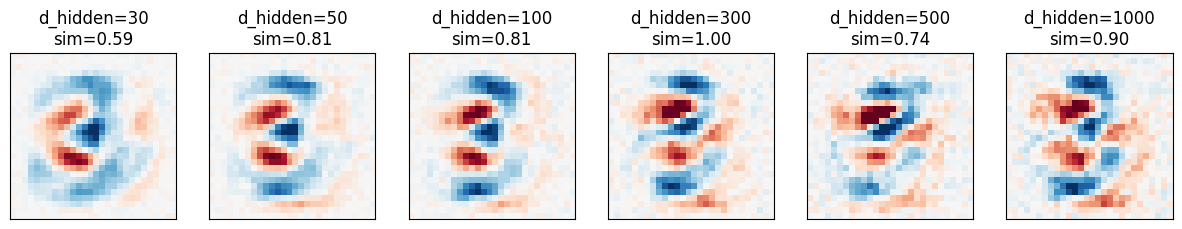

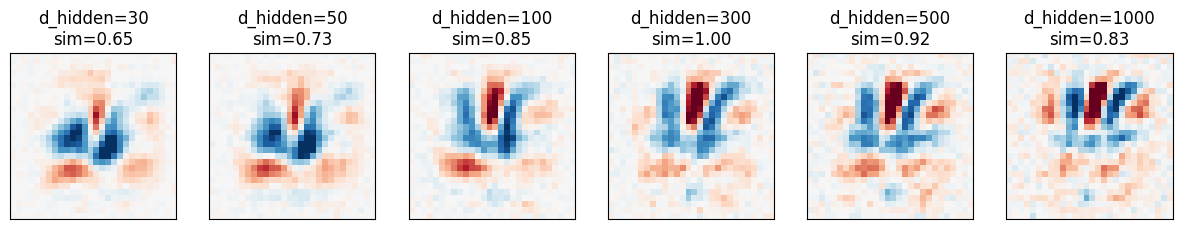

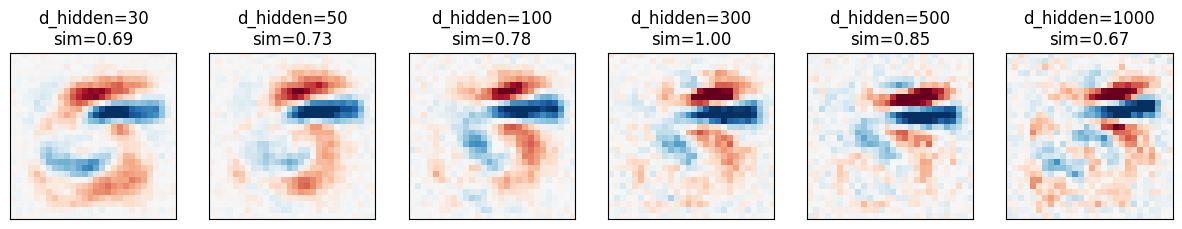

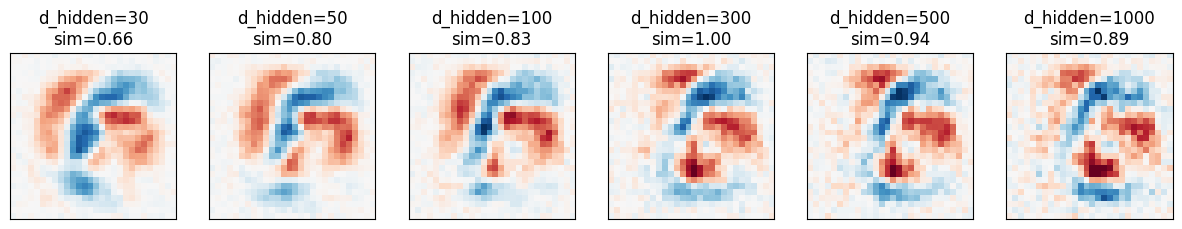

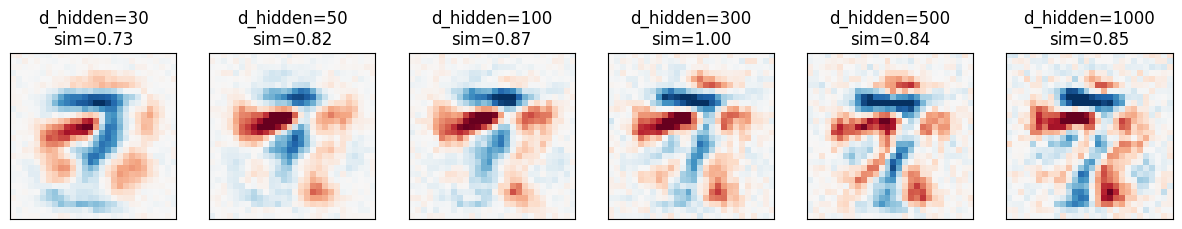

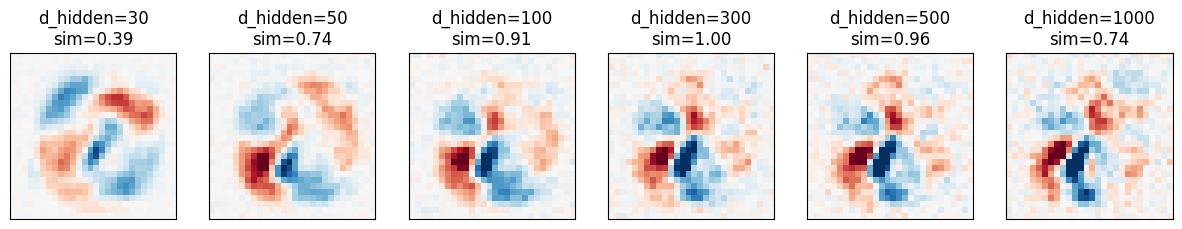

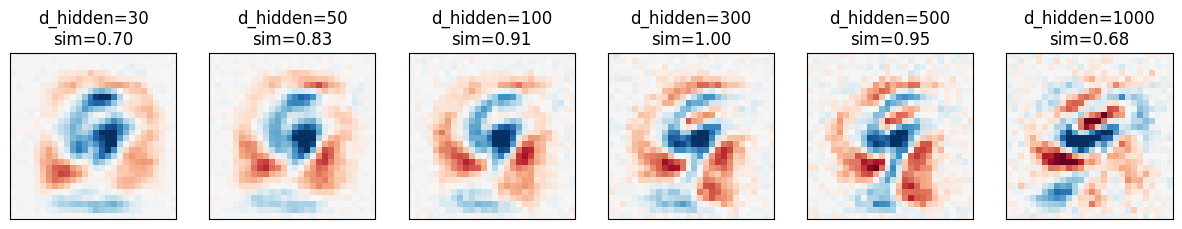

In [ ]:
hidden_ref = 300
i = 0
eig_idx = -1

hiddens = np.array(hidden_dims)


for class_idx in range(10):
    plt.figure(figsize=(15,4))
    for idx, hidden in enumerate(hiddens):

        eigvecs0 = einops.einsum(eigvecs_dict[(hidden_ref,i)][class_idx], W_in_dict[(hidden_ref,i)], "h eig, h pix -> eig pix")
        eigvecs1 = einops.einsum(eigvecs_dict[(hidden,i)][class_idx], W_in_dict[(hidden,i)], "h eig, h pix -> eig pix")
        sims = einops.einsum(eigvecs0 /eigvecs0.norm(dim=-1, keepdim=True),
                            eigvecs1 /eigvecs1.norm(dim=-1, keepdim=True),
                            "eig1 pix, eig2 pix  -> eig1 eig2")
        max_sim = sims.abs().max(dim=-1)

        plt.subplot(1,len(hiddens),idx+1)
        eig_idx2 = max_sim.indices[eig_idx]
        plt.imshow(sims[eig_idx, eig_idx2].sign() * eigvecs1[eig_idx2].reshape(28,28), cmap='RdBu_r', vmin=-0.25, vmax=0.25)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'd_hidden={hidden}\nsim={max_sim.values[eig_idx]:.2f}')
    plt.show()

# Singular Value Decomposition

From the bilinear layer's weight matrices, $W$ and $V$ ( which include the biases as their final column), we can construct the bilinear tensor as
\begin{align}
B_{ijk} = \frac{1}{2}W_{ij} V_{ik} + \frac{1}{2}V_{ij} W_{ik}
\end{align}
Since the $j,k$ indices are both summed over the input, only the symmetric part of $W_{ij}V_{ik}$ contributes, so we've only kept this symmetric part in $B$.

We'll take the SVD over the matrix $B_{i(jk)}$ where the input indices $j,k$ are treated as a single index $(jk)$. SVD then results in a decomposition $B_{i(jk)} = R_{is} \Sigma_{ss'} (Q_{(jk)s'})^T$, where $R$ contains orthogonal output vectors, $S$ is a diagonal matrix of singular values, and $Q$ contains orthongal input vectors.

The columns of $Q$ can be treated as a matrix with indices $j,k$. The output for the bilinear layer can then be written as
\begin{align}
y_i = \sum_{jk} B_{ijk}x_jx_k = \sum_s R_{is} \sigma_s (x^T Q^s x)
\end{align}

It can be difficult to interpret the matrix $Q^s$, so we can go one step further by doing an eigendecomposition. Since $Q^s$ is symmetric, the eigenvalues $\lambda$ are all real and the eigenvectors $q$ are orthogonal, so $Q^s = \sum_i \lambda^s_k (q_k q_k^T)$.  

The output in terms of the eigenvectors $q$ is
\begin{align}
\vec{y} = \sum_{sk} \ \vec{r}_s \ \sigma_s \ \lambda^s_k \ (q_s^Tx)^2
\end{align}

In [ ]:
W = model.layers[0].linear1.weight.cpu().detach()
V = model.layers[0].linear2.weight.cpu().detach()

W_out = model.linear_out.weight.to("cpu").detach()
W_in = model.linear_in.weight.to("cpu").detach()

# svd = compute_symmetric_svd(W, V)
B_proj = einops.einsum(W_out, W, V, "class h, h in1, h in2 -> class in1 in2")
B_proj = 0.5 * B_proj + 0.5 * B_proj.transpose(-2,-1)
svd = torch.svd(B_proj.reshape(B_proj.shape[0], -1))

In [ ]:
logits = svd.U
B_svd = einops.rearrange(svd.V, "(in1 in2) comp -> comp in1 in2", in1 = model.cfg.d_hidden)

In [ ]:
model.linear_out.bias

Parameter containing:
tensor([-0.0685,  0.0239,  0.0026, -0.0791,  0.0209,  0.0755,  0.0129, -0.0105,
         0.0062,  0.0191], device='cuda:0', requires_grad=True)

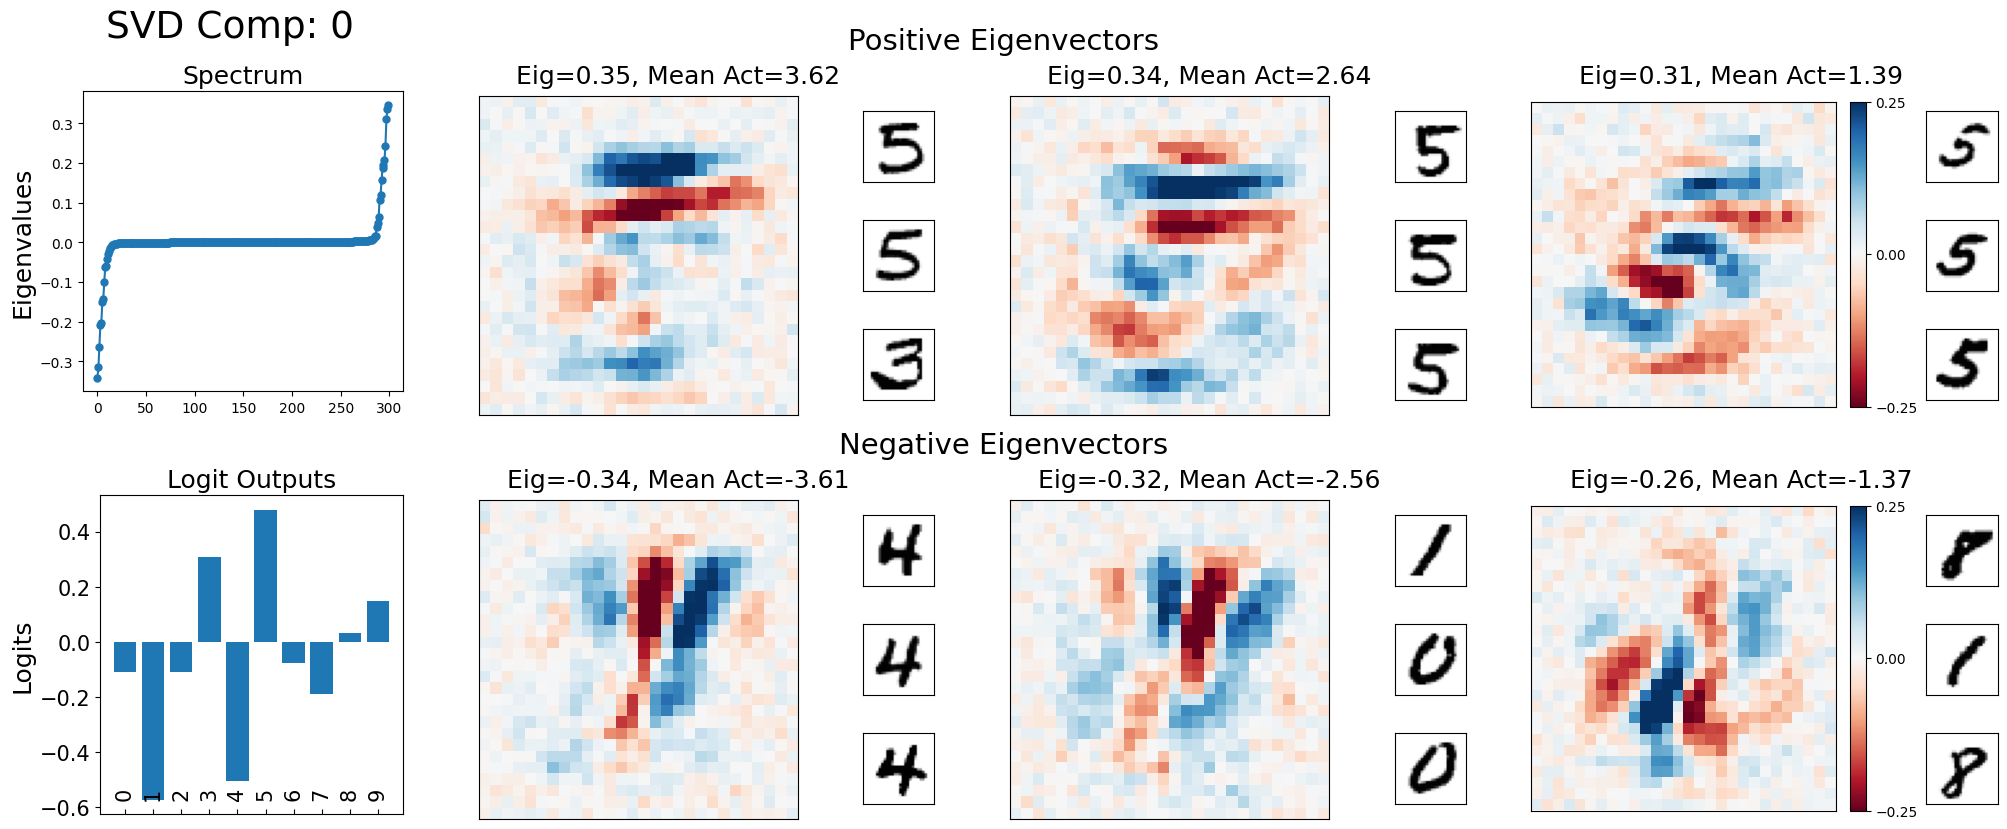

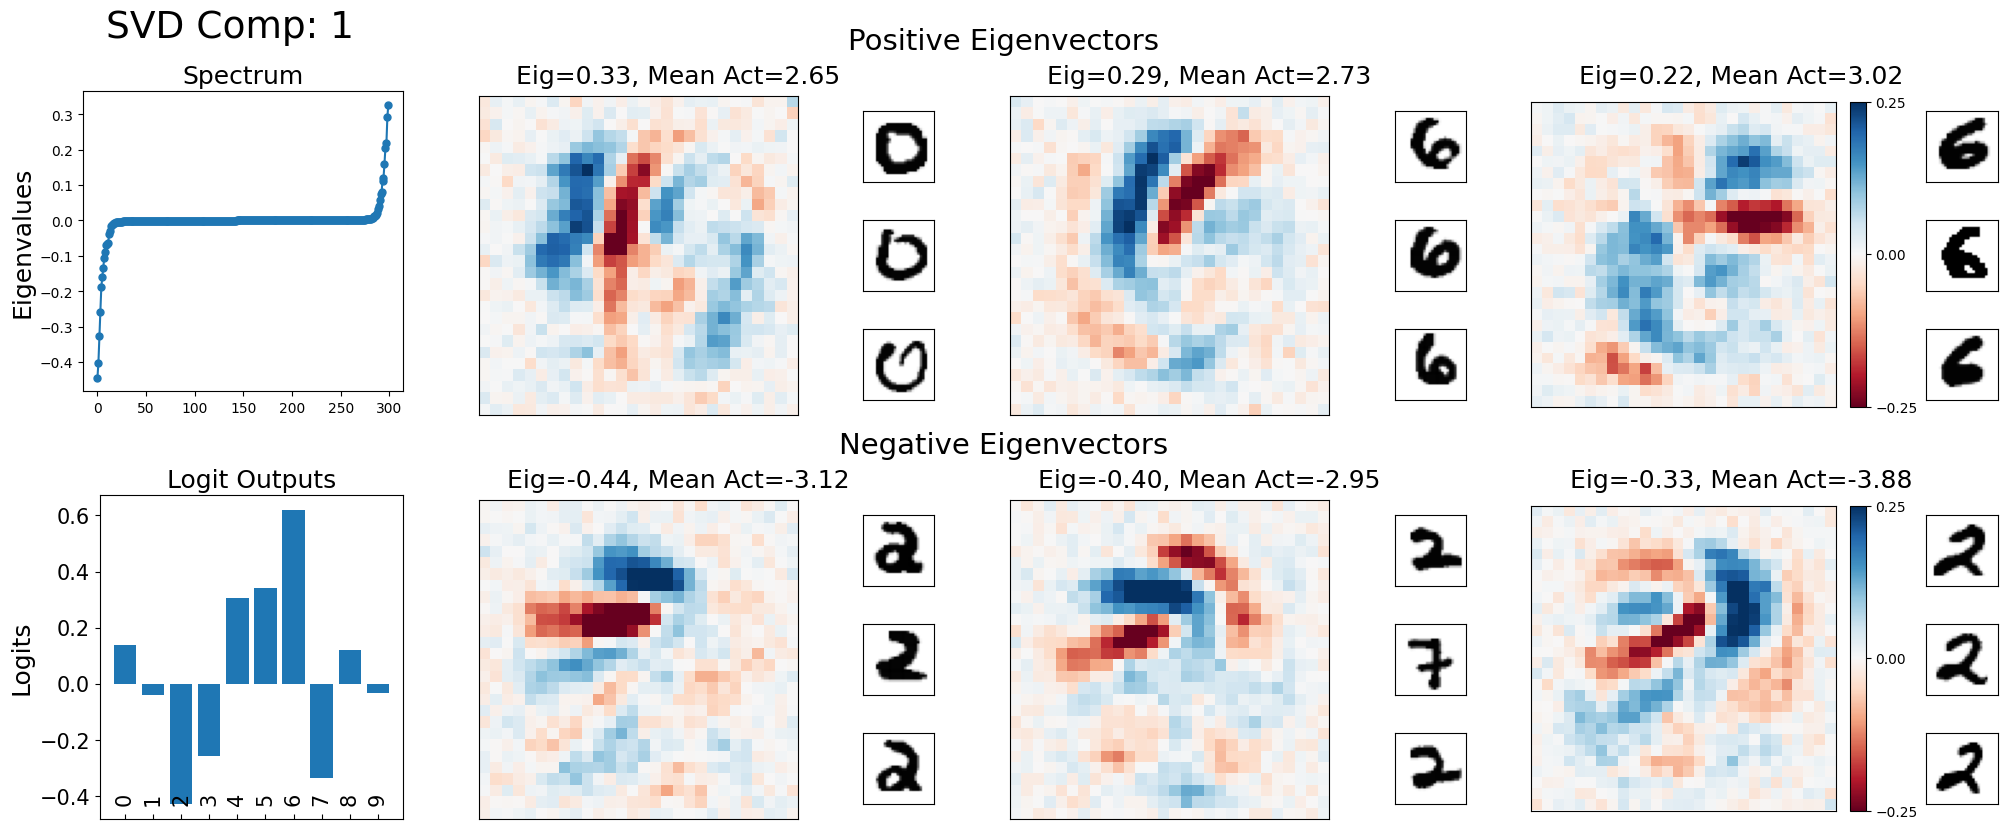

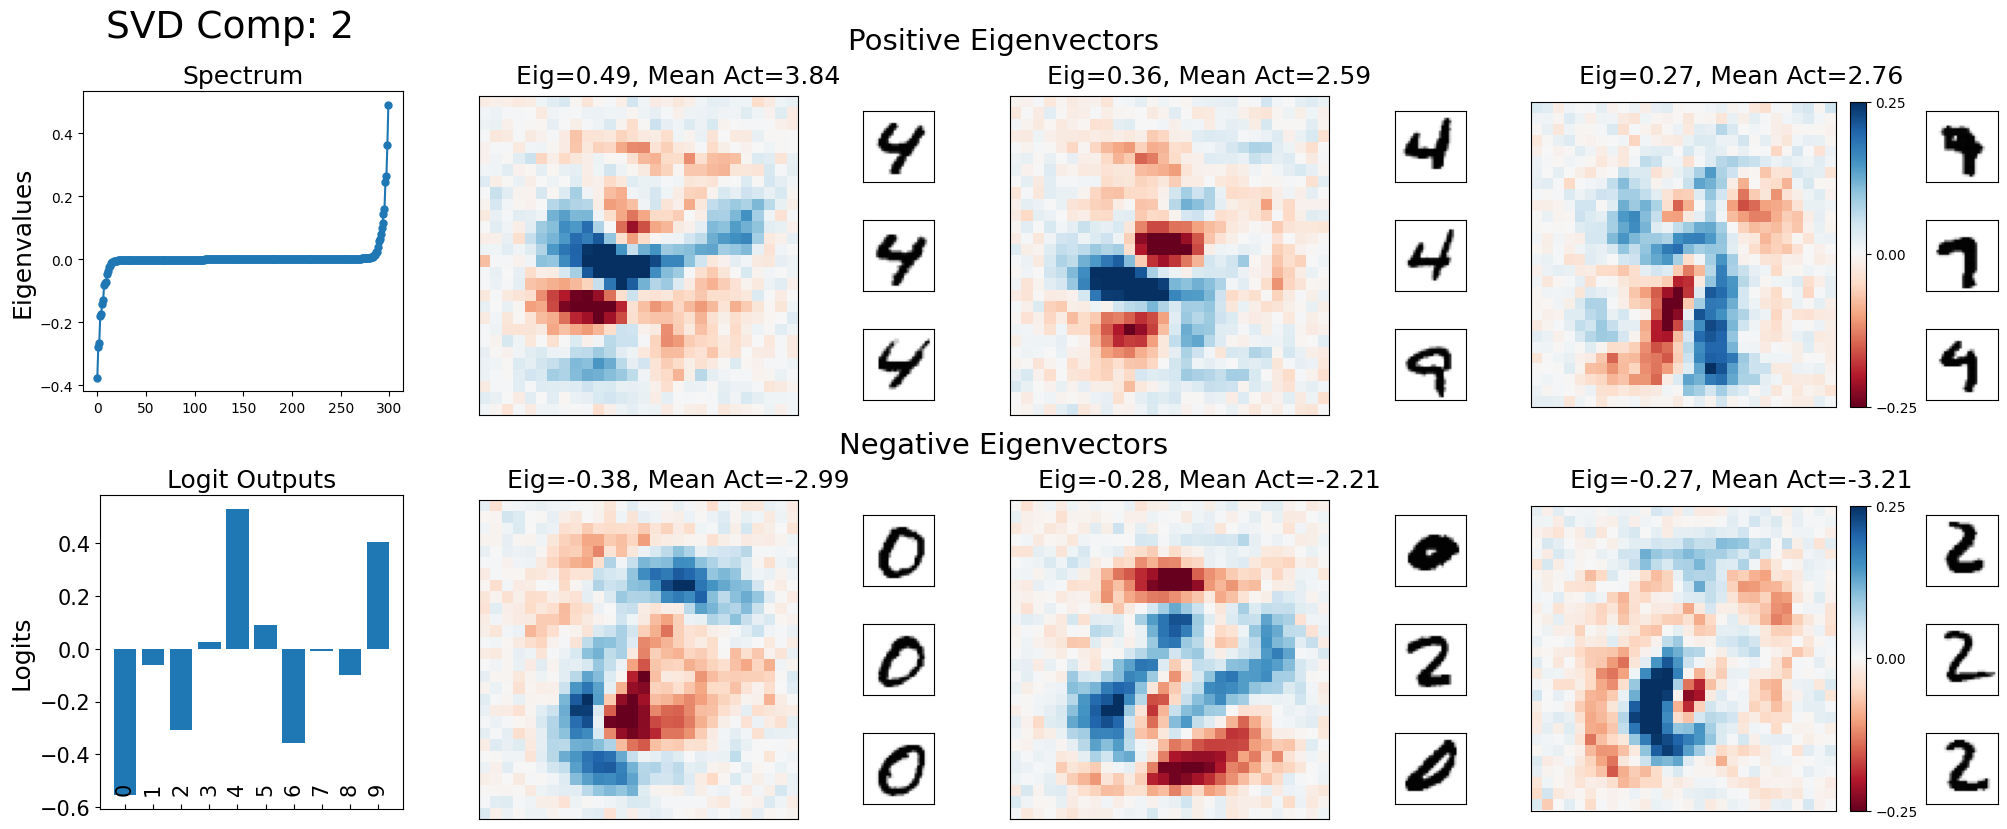

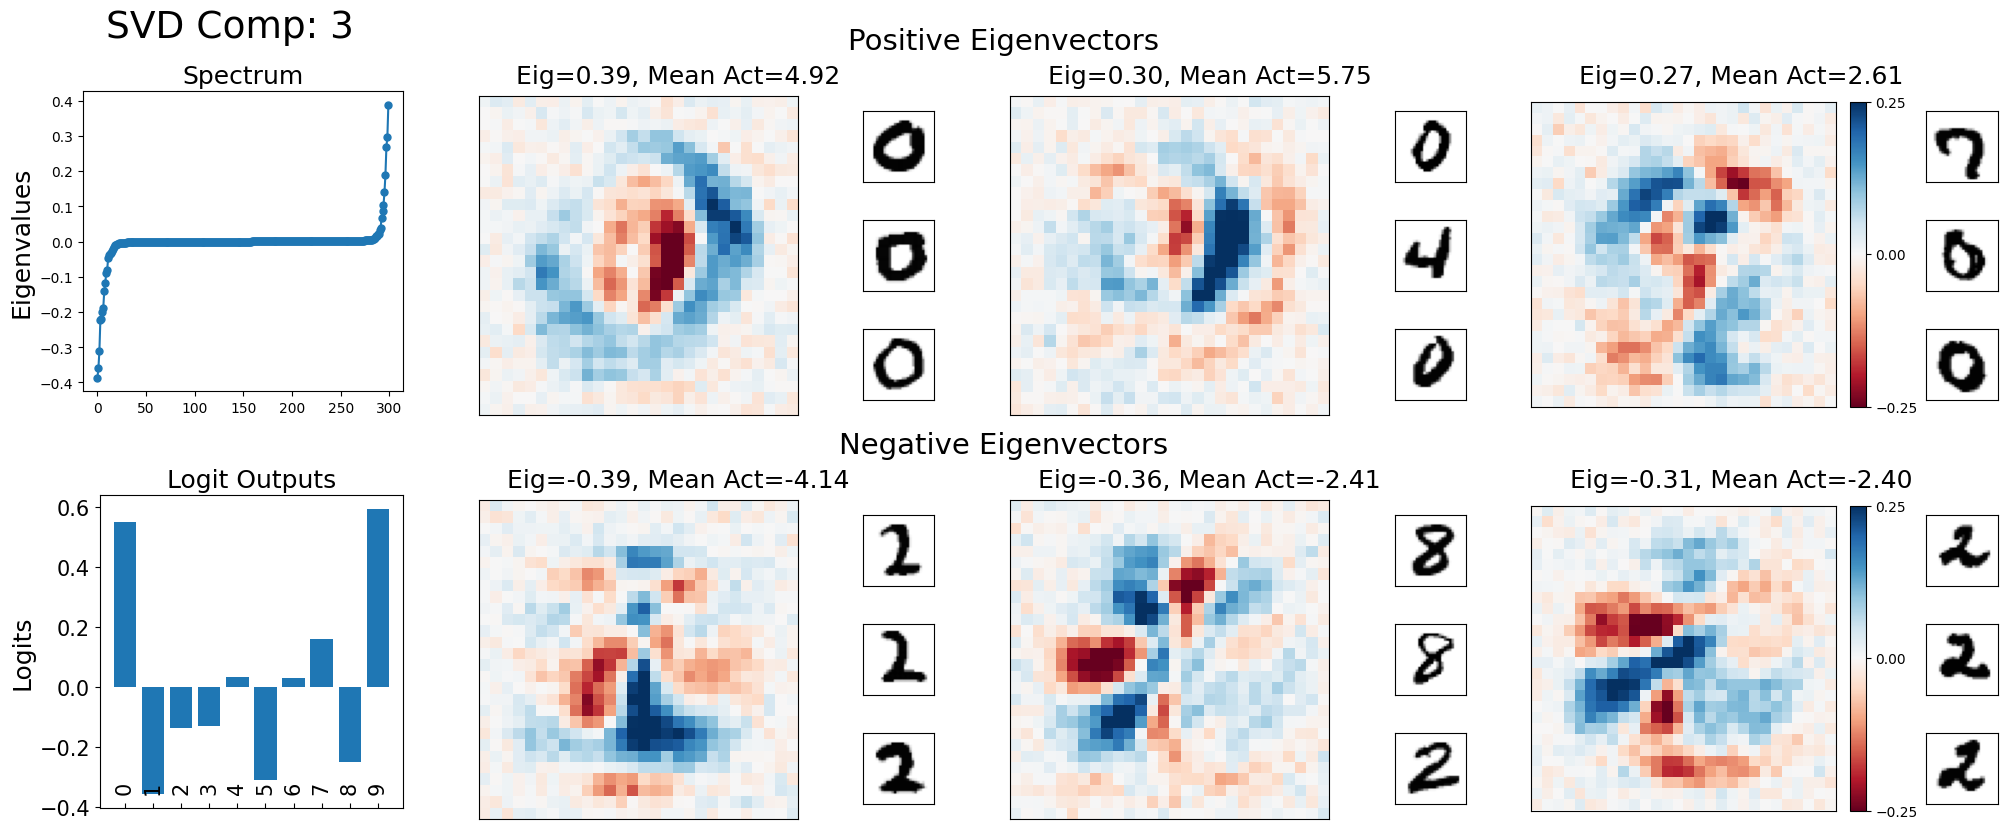

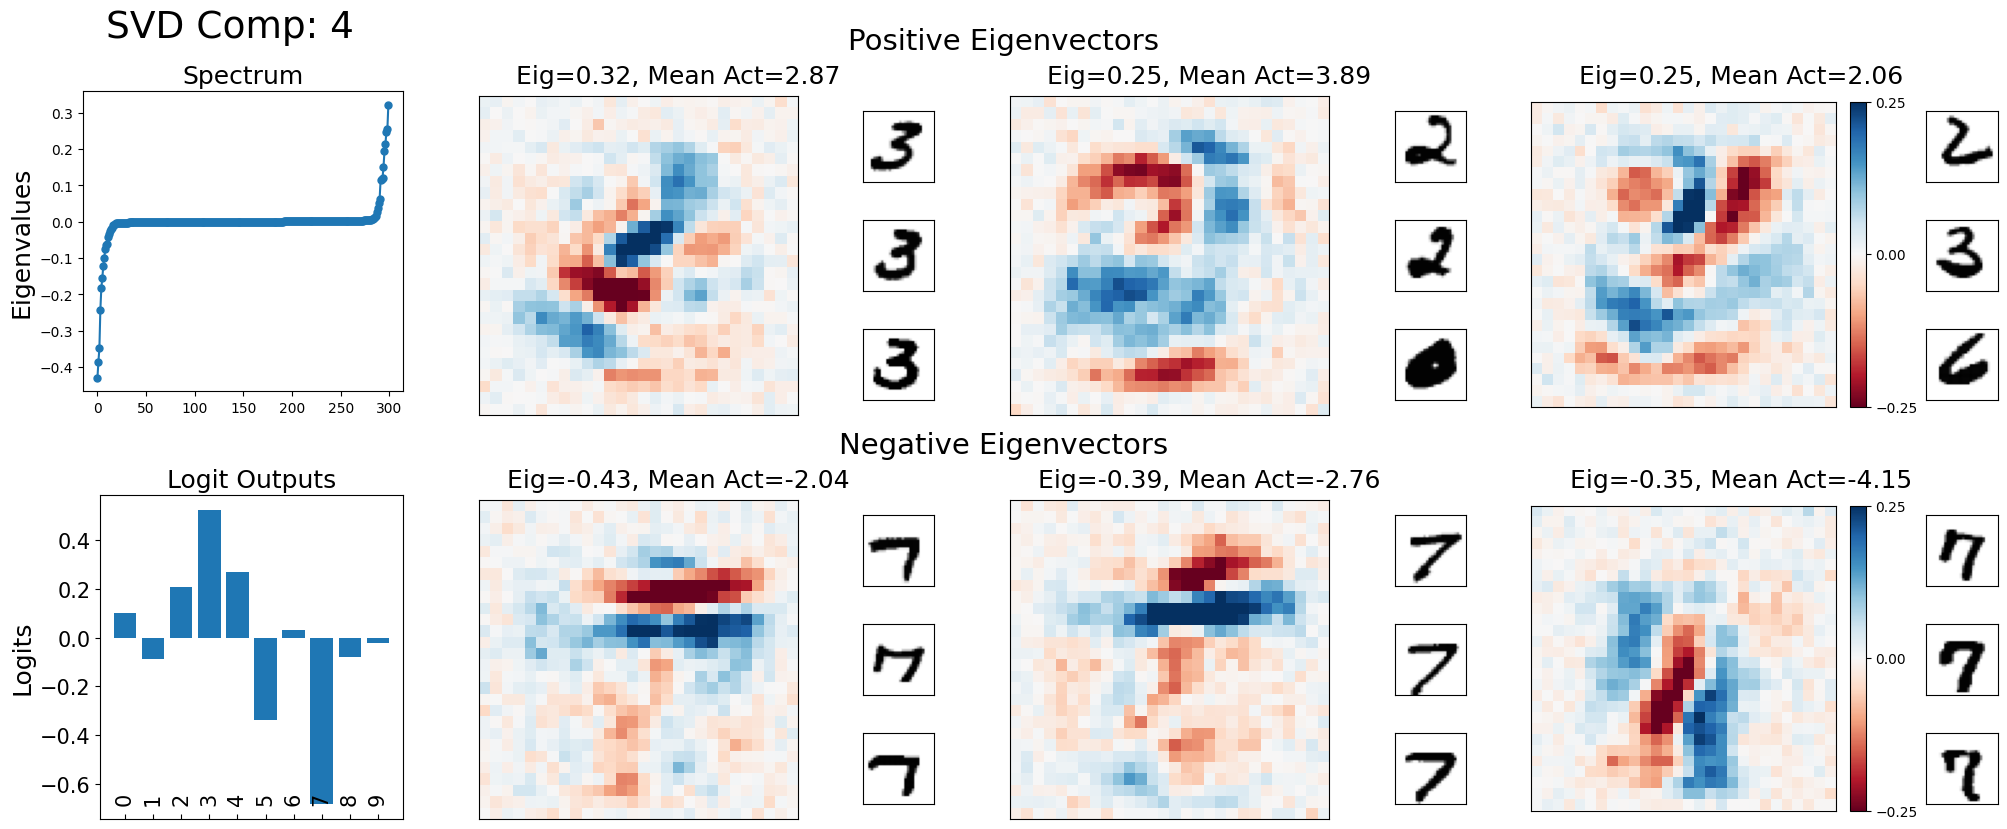

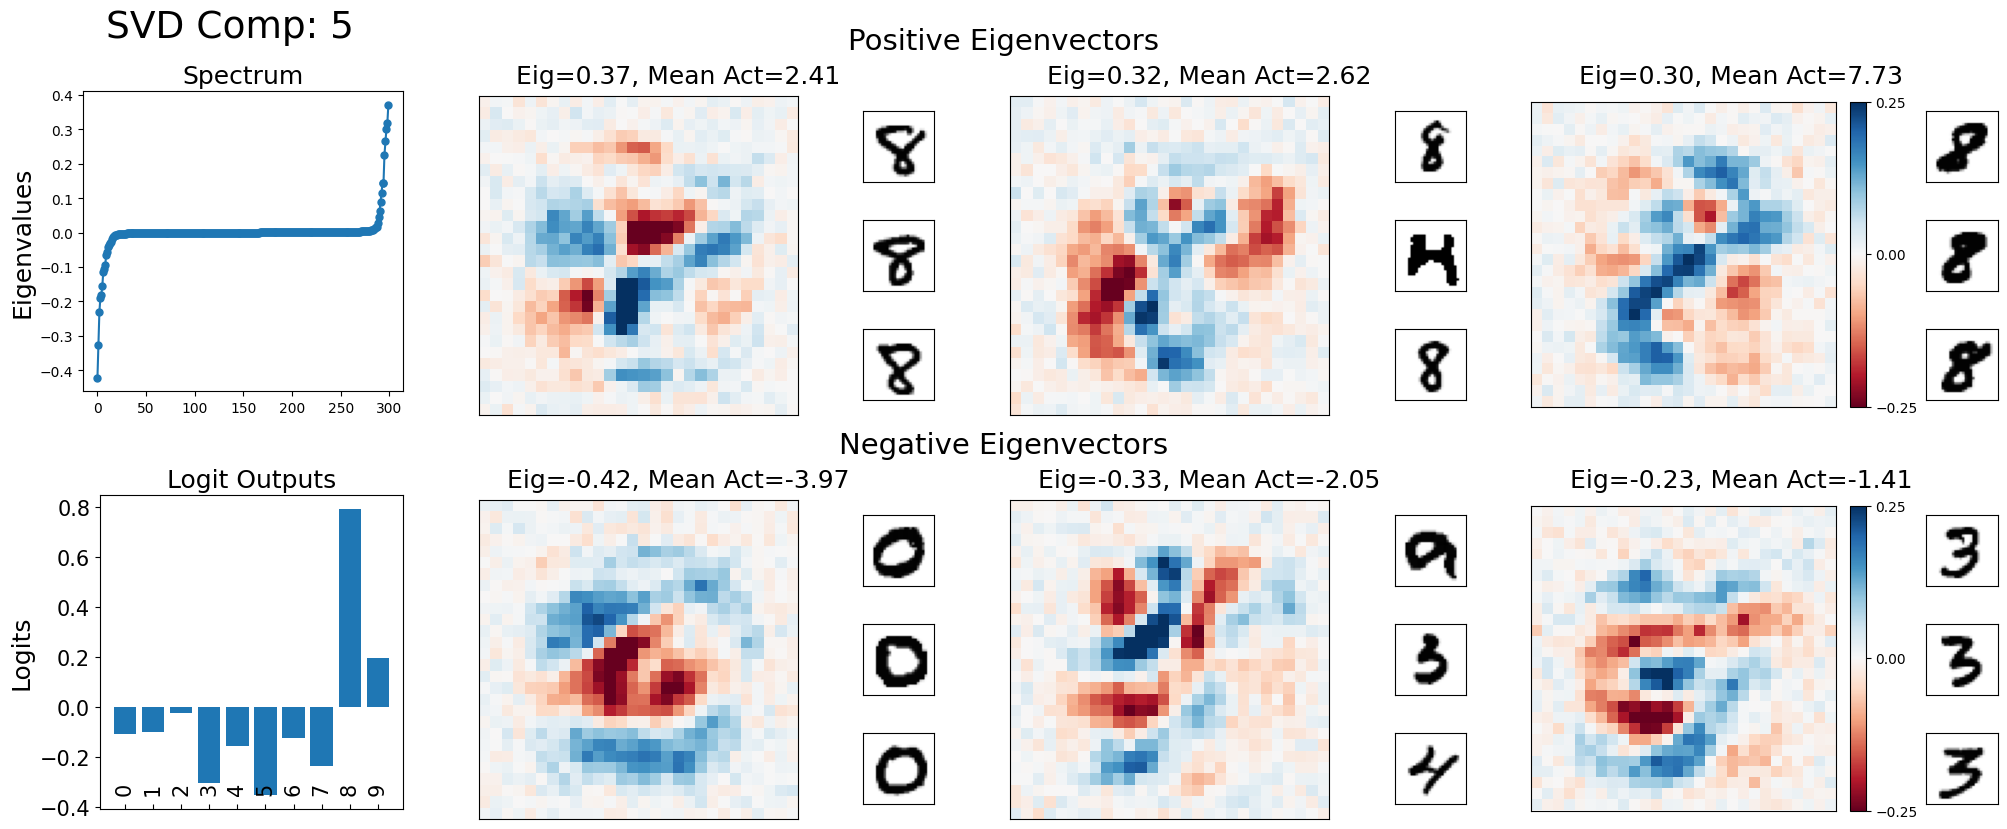

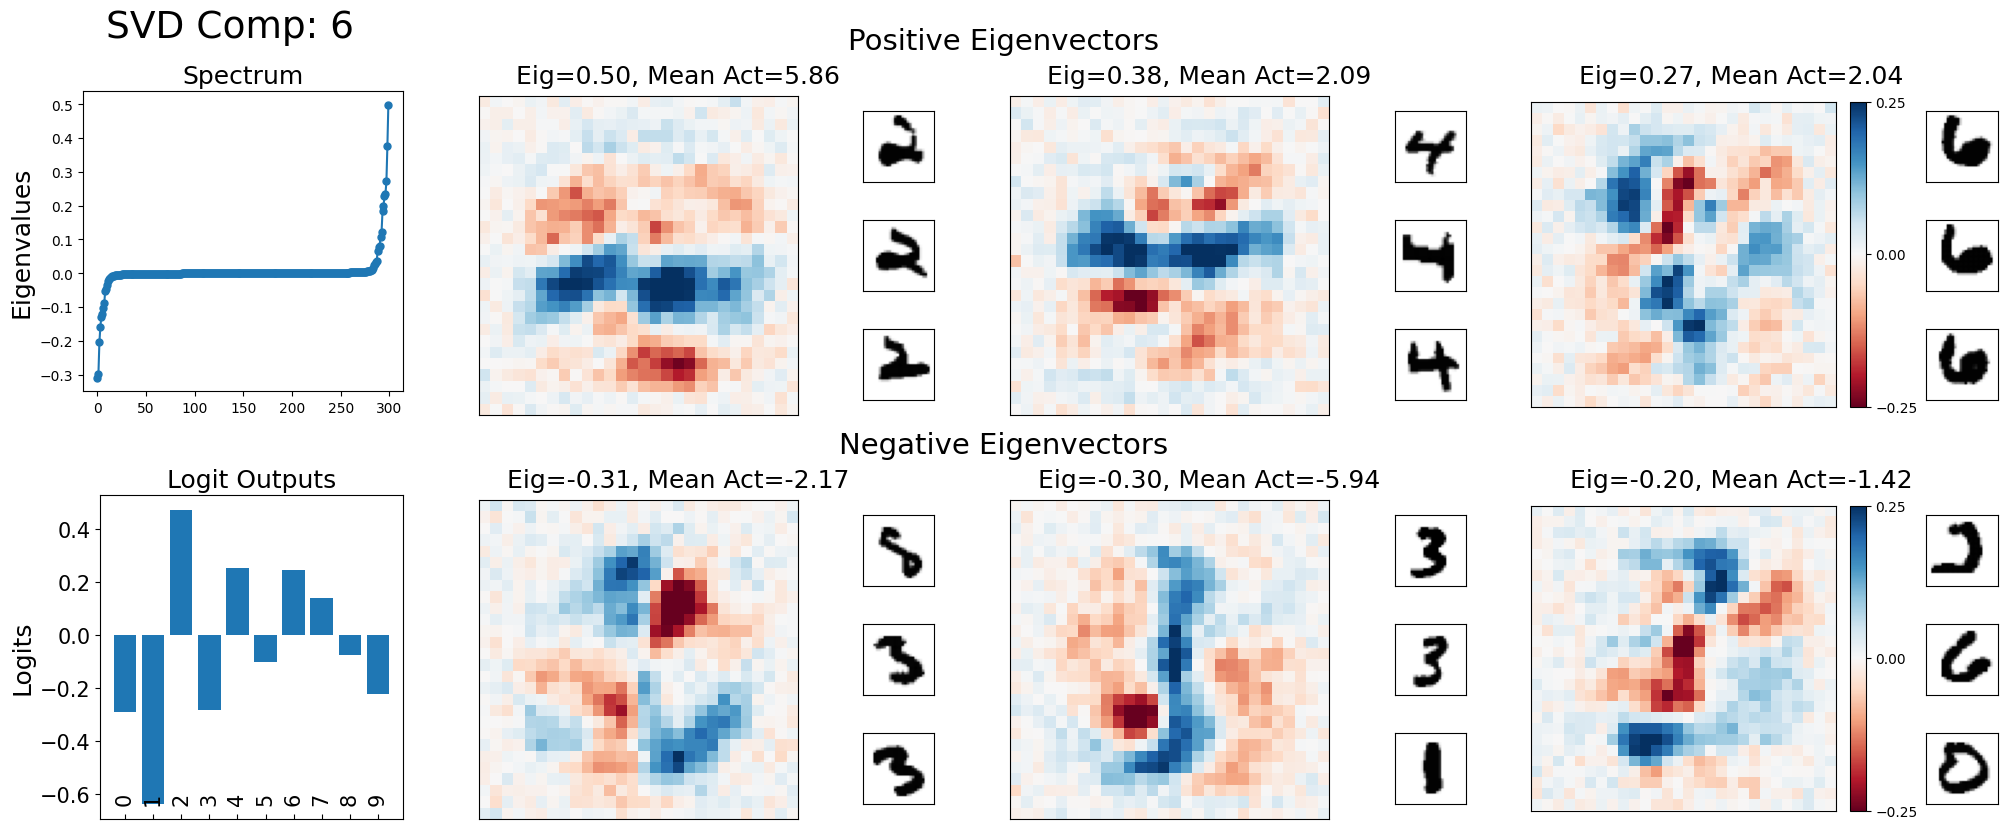

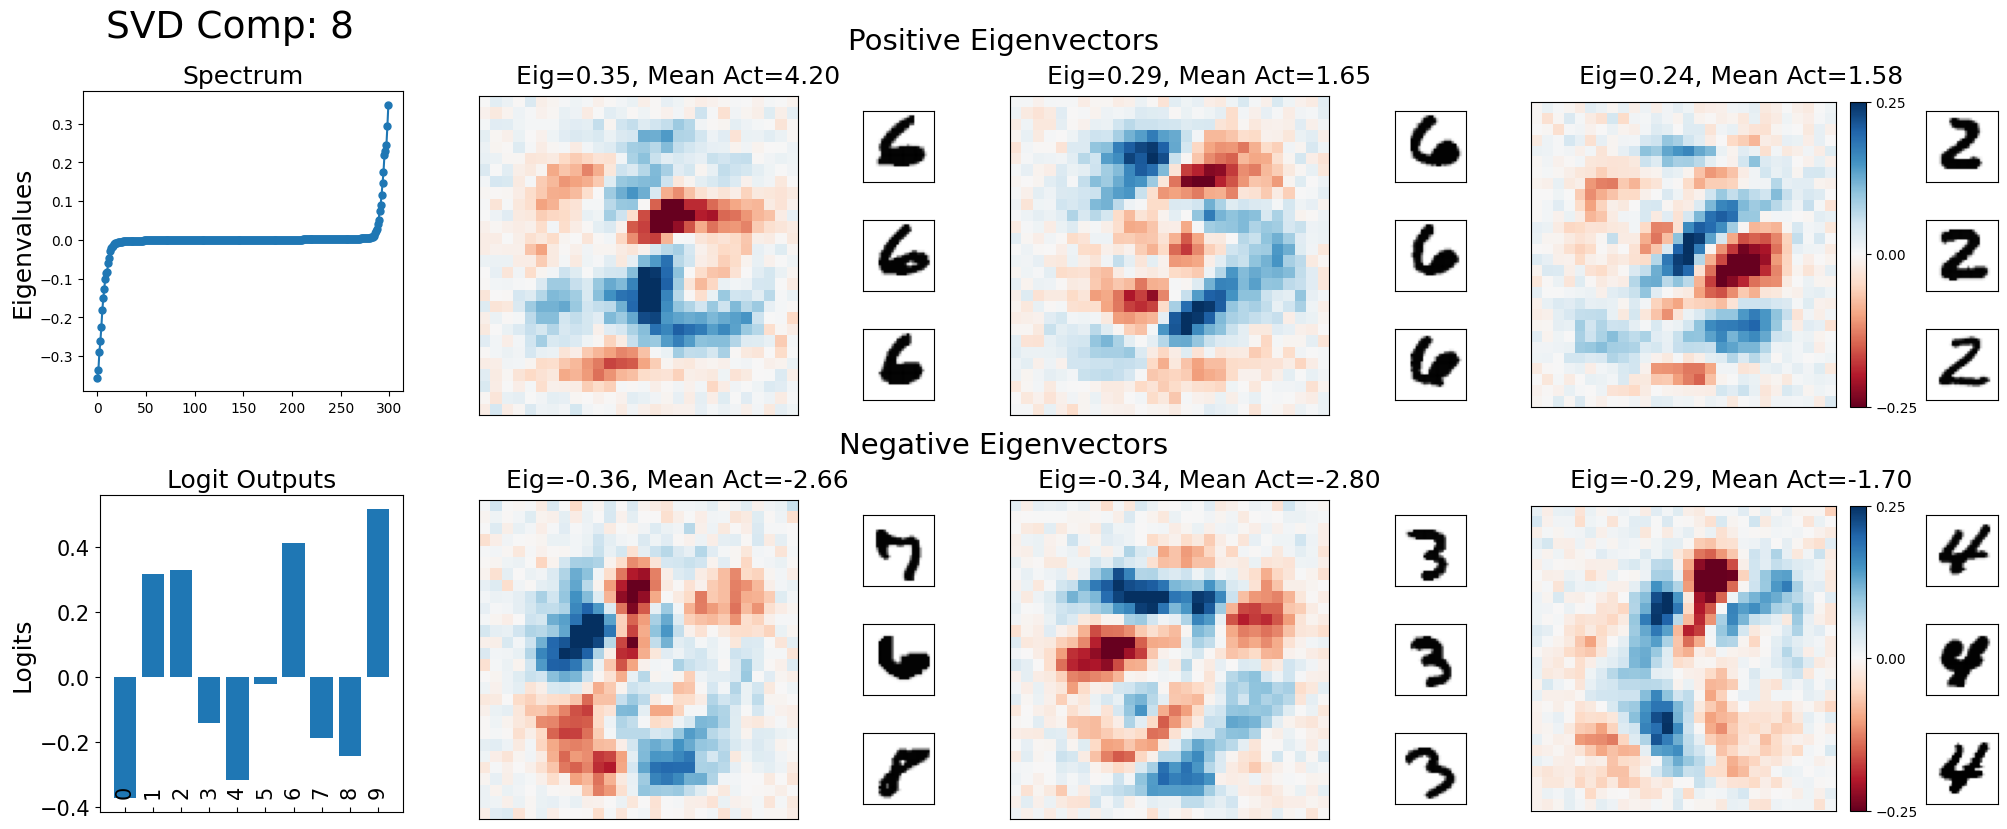

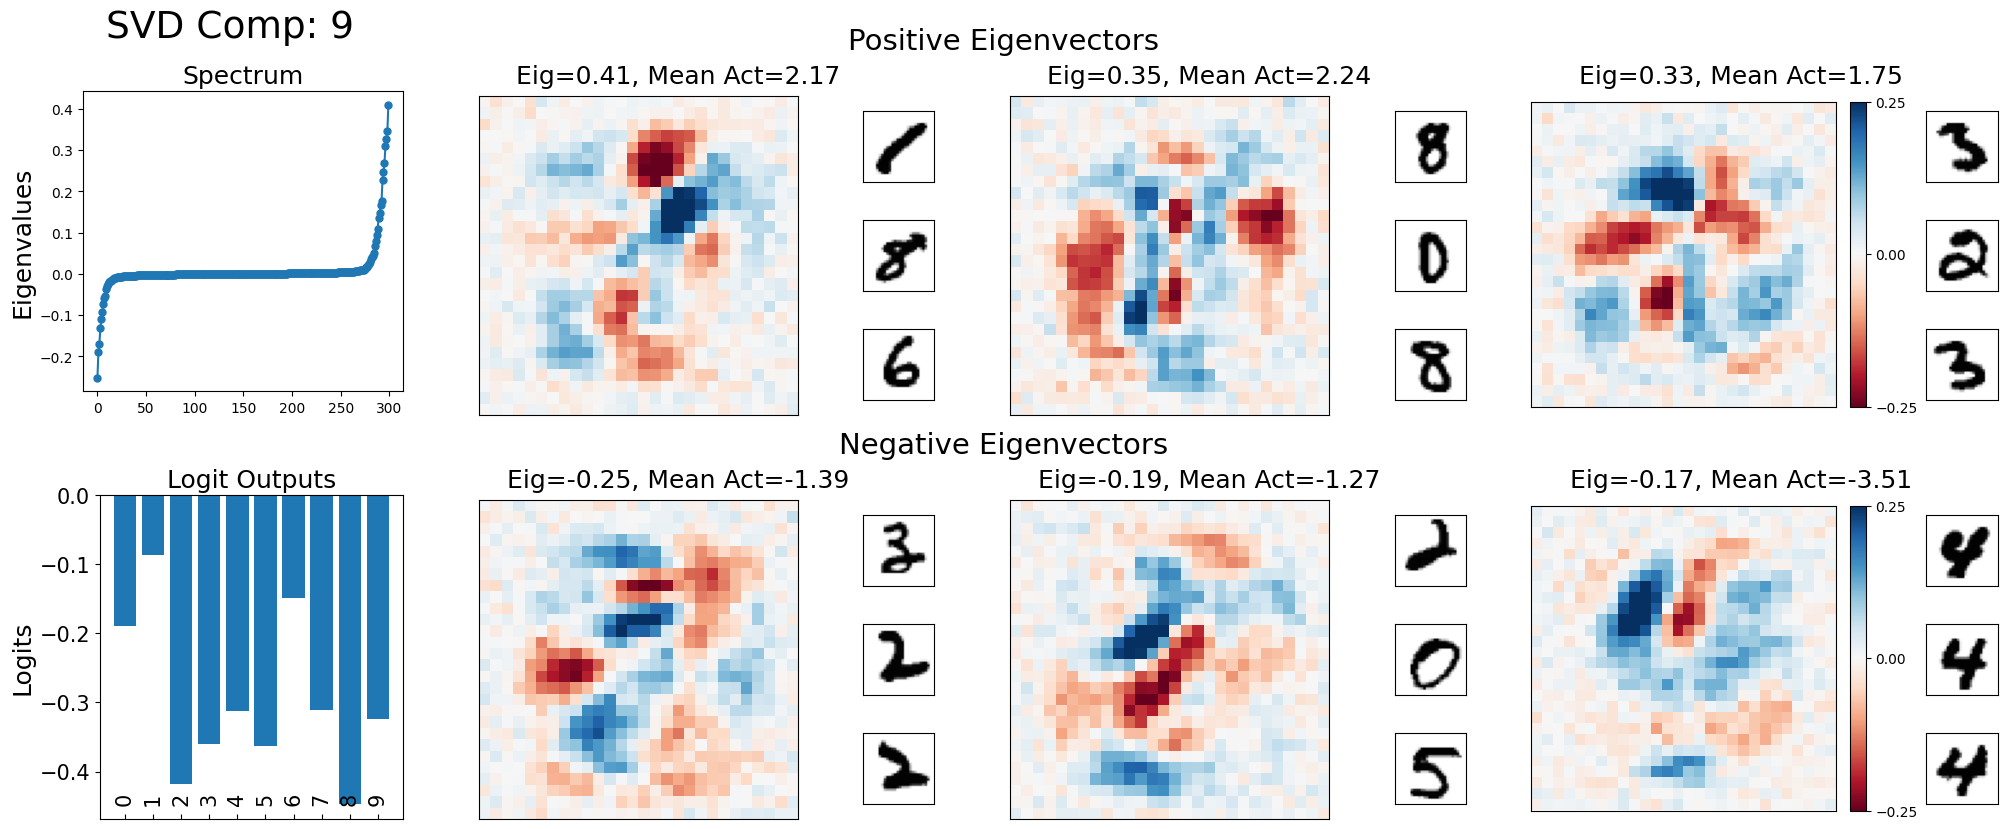

In [ ]:
eig_plotter = EigenvectorPlotter(B_svd, logits.T, dataset=train_dataset, Embed = W_in)

for i in range(10):
    eig_plotter.plot_component(i, suptitle=f"SVD Comp: {i}", vmax=0.25,
                               classes = range(10), topk_eigs = 3, sort='eigs')


Text(0, 0.5, 'Singular value')

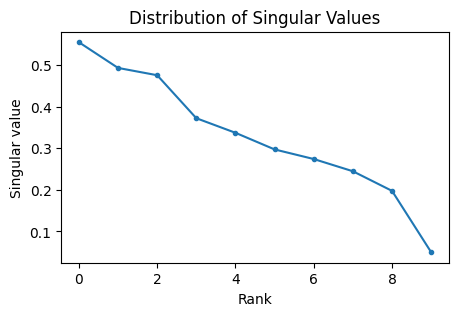

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(len(svd.S)), svd.S.cpu().detach().numpy(),'.-')
# plt.yscale('log')

plt.title('Distribution of Singular Values')
plt.xlabel('Rank')
plt.ylabel('Singular value')

## Performance Curve

In [ ]:
num_pixels = 784
input_idxs = get_top_pixel_idxs(train_loader, num_pixels, bias_idx = None)

svd_components = 350
sing_val_type = 'with R'

model = model.to("cpu")
model.cfg.device = "cpu"
svds = compute_svds_for_deep_model(model, svd_components, input_idxs, sing_val_type=sing_val_type)

In [ ]:
topK_list = [1] + list(range(2,20,2)) + list(range(20,50,10)) + list(range(50,350,50)) + [350]

plot_topk_model_bottleneck(model, svds, topK_list, test_loader,
    input_idxs, svd_components, sing_val_type, print_bool = False)

100%|██████████| 1/1 [03:25<00:00, 205.49s/it]
